In [ ]:
import os
import pickle
import pandas as pd
from typing import List

from datetime import datetime
from pydantic import BaseModel
from sqlalchemy import create_engine
from fastapi import FastAPI, Depends, HTTPException

app = FastAPI()

class PostGet(BaseModel):
    id: int
    text: str
    topic: str
    class Config:
        orm_mode = True

def get_model_path(path: str) -> str:
    if os.environ.get("IS_LMS") == "1":  # проверяем где выполняется код в лмс, или локально. Немного магии
        MODEL_PATH = '/workdir/user_input/model'
    else:
        MODEL_PATH = path
    return MODEL_PATH

def load_model():
    model_path = get_model_path("sklearn_model.pkl") # указать папку
    model = pickle.load(open(model_path, 'rb'))
    return model

def batch_load_sql(query: str) -> pd.DataFrame:
    CHUNKSIZE = 200000
    engine = create_engine(
        "postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml"
    )
    conn = engine.connect().execution_options(stream_results=True)
    chunks = []
    for chunk_dataframe in pd.read_sql(query, conn, chunksize=CHUNKSIZE):
        chunks.append(chunk_dataframe)
    conn.close()
    return pd.concat(chunks, ignore_index=True)

def load_features() -> pd.DataFrame:
    user_cf = batch_load_sql('SELECT * FROM bardin777_user_features_lesson_22')
    post_cf = batch_load_sql('SELECT * FROM bardin777_post_features_lesson_22')
    # likes = batch_load_sql("SELECT * FROM feed_data WHERE action = 'like' LIMIT 100000")
    return [user_cf, post_cf]



model = load_model()
loaded_data = load_features()

@app.get("/post/recommendations/", response_model=List[PostGet])

def get_recommended_posts(id: int, timestamp:datetime, limit: int = 5) -> List[PostGet]:
    return recommended_posts(id, timestamp, limit)

In [ ]:
import pandas as pd
from sqlalchemy import create_engine

engine = create_engine(
    "postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
    "postgres.lab.karpov.courses:6432/startml"
)

query = """
SELECT * FROM (
    SELECT *,
           ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY timestamp DESC) AS rn
    FROM public.feed_data
    WHERE action = 'view'
) AS sub
WHERE rn <= 30;
"""


with engine.connect() as connection:
    df1 = pd.read_sql('SELECT * FROM public.user_data;', con=connection)
    df2 = pd.read_sql('SELECT * FROM public.post_text_df;', con=connection)
    df3 = pd.read_sql(query, con=connection)

print(df3.info(memory_usage='deep'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4896150 entries, 0 to 4896149
Data columns (total 6 columns):
 #   Column     Dtype         
---  ------     -----         
 0   timestamp  datetime64[ns]
 1   user_id    int64         
 2   post_id    int64         
 3   action     object        
 4   target     int64         
 5   rn         int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 434.2 MB
None


In [3]:
print(df1.info(memory_usage='deep'))
print(df2.info(memory_usage='deep'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163205 entries, 0 to 163204
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    163205 non-null  int64 
 1   gender     163205 non-null  int64 
 2   age        163205 non-null  int64 
 3   country    163205 non-null  object
 4   city       163205 non-null  object
 5   exp_group  163205 non-null  int64 
 6   os         163205 non-null  object
 7   source     163205 non-null  object
dtypes: int64(4), object(4)
memory usage: 39.5 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7023 entries, 0 to 7022
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   post_id  7023 non-null   int64 
 1   text     7023 non-null   object
 2   topic    7023 non-null   object
dtypes: int64(1), object(2)
memory usage: 9.6 MB
None


In [4]:
df1

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads
...,...,...,...,...,...,...,...,...
163200,168548,0,36,Russia,Kaliningrad,4,Android,organic
163201,168549,0,18,Russia,Tula,2,Android,organic
163202,168550,1,41,Russia,Yekaterinburg,4,Android,organic
163203,168551,0,38,Russia,Moscow,3,iOS,organic


In [38]:
df2

,post_id,text,topic,like_count
0,1,UK economy facing major risks\n\nThe UK manufa...,business,84
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,58
2,3,Asian quake hits European shares\n\nShares in ...,business,86
3,4,India power shares jump on debut\n\nShares in ...,business,104
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,88
...,...,...,...,...
7018,7315,"OK, I would not normally watch a Farrelly brot...",movie,192
7019,7316,I give this movie 2 stars purely because of it...,movie,52
7020,7317,I cant believe this film was allowed to be mad...,movie,63
7021,7318,The version I saw of this film was the Blockbu...,movie,65


In [6]:
df3

,timestamp,user_id,post_id,action,target,rn
0,2021-12-29 15:24:59,200,1773,view,0,1
1,2021-12-29 15:24:31,200,2213,view,1,2
2,2021-12-29 15:23:54,200,1122,view,0,3
3,2021-12-29 15:23:29,200,1362,view,0,4
4,2021-12-29 15:21:53,200,1541,view,0,5
...,...,...,...,...,...,...
4896145,2021-12-23 10:17:08,168552,4284,view,0,26
4896146,2021-12-21 09:31:07,168552,5487,view,1,27
4896147,2021-12-21 09:29:21,168552,1966,view,0,28
4896148,2021-12-21 09:27:37,168552,6107,view,0,29


In [7]:
df2['topic'].unique()

array(['business', 'covid', 'entertainment', 'sport', 'politics', 'tech',
       'movie'], dtype=object)

In [12]:
len(df1['os'].unique())

2

In [159]:
len(df1['city'].unique())

3915

In [9]:
len(df3['user_id'].unique())

163205

In [7]:
len(df3['post_id'].unique())

6831

In [13]:
# Объединяем feed_data с user_data (по user_id)
merged = df3.merge(df1[['user_id', 'exp_group']], on='user_id', how='left')

# Объединяем с df2 (по post_id, чтобы получить topic)
merged = merged.merge(df2[['post_id', 'topic']], on='post_id', how='left')

# Фильтруем по действию, если нужно (например, только 'view')
merged = merged[merged['action'] == 'view']

# Считаем средний target по exp_group и topic
result = merged.groupby(['exp_group', 'topic'])['target'].mean().reset_index()

# Смотрим результат
print(result)


    exp_group          topic    target
0           0       business  0.104146
1           0          covid  0.103029
2           0  entertainment  0.106120
3           0          movie  0.104830
4           0       politics  0.097806
5           0          sport  0.107356
6           0           tech  0.081921
7           1       business  0.162203
8           1          covid  0.159334
9           1  entertainment  0.163101
10          1          movie  0.162402
11          1       politics  0.152447
12          1          sport  0.165200
13          1           tech  0.138708
14          2       business  0.159921
15          2          covid  0.159822
16          2  entertainment  0.164079
17          2          movie  0.160963
18          2       politics  0.152857
19          2          sport  0.162992
20          2           tech  0.140623
21          3       business  0.102889
22          3          covid  0.103919
23          3  entertainment  0.111161
24          3          mo

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Объединяем таблицы
merged = df3.merge(df1[['user_id', 'exp_group']], on='user_id', how='left')
merged = merged.merge(df2[['post_id', 'topic']], on='post_id', how='left')

# Оставляем только action == 'view'
merged = merged[merged['action'] == 'view']

# Группируем по exp_group и topic
grouped = merged.groupby(['exp_group', 'topic'])['target'].mean().reset_index()


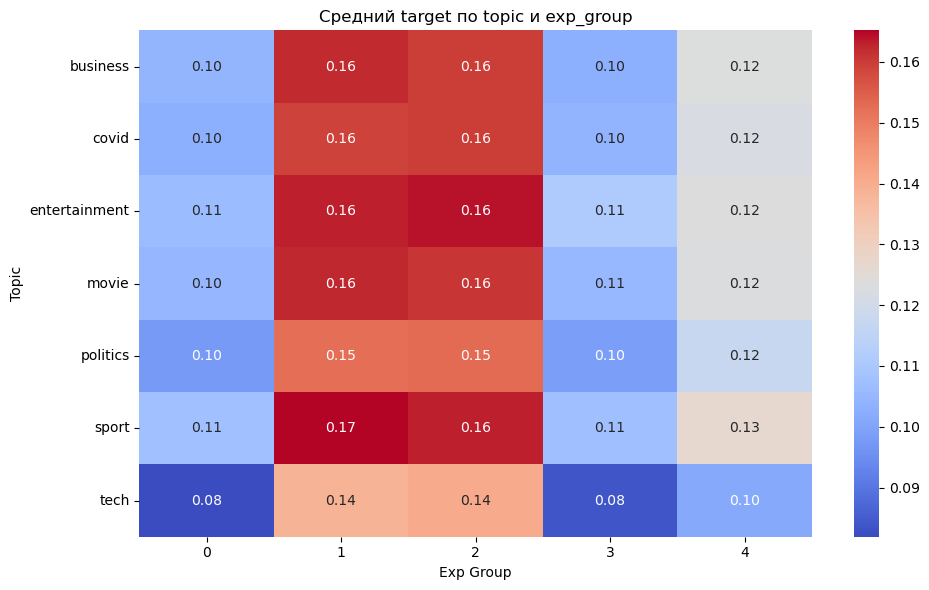

In [15]:
# Преобразуем в таблицу для тепловой карты
pivot_table = grouped.pivot(index='topic', columns='exp_group', values='target')

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Средний target по topic и exp_group')
plt.ylabel('Topic')
plt.xlabel('Exp Group')
plt.tight_layout()
plt.show()


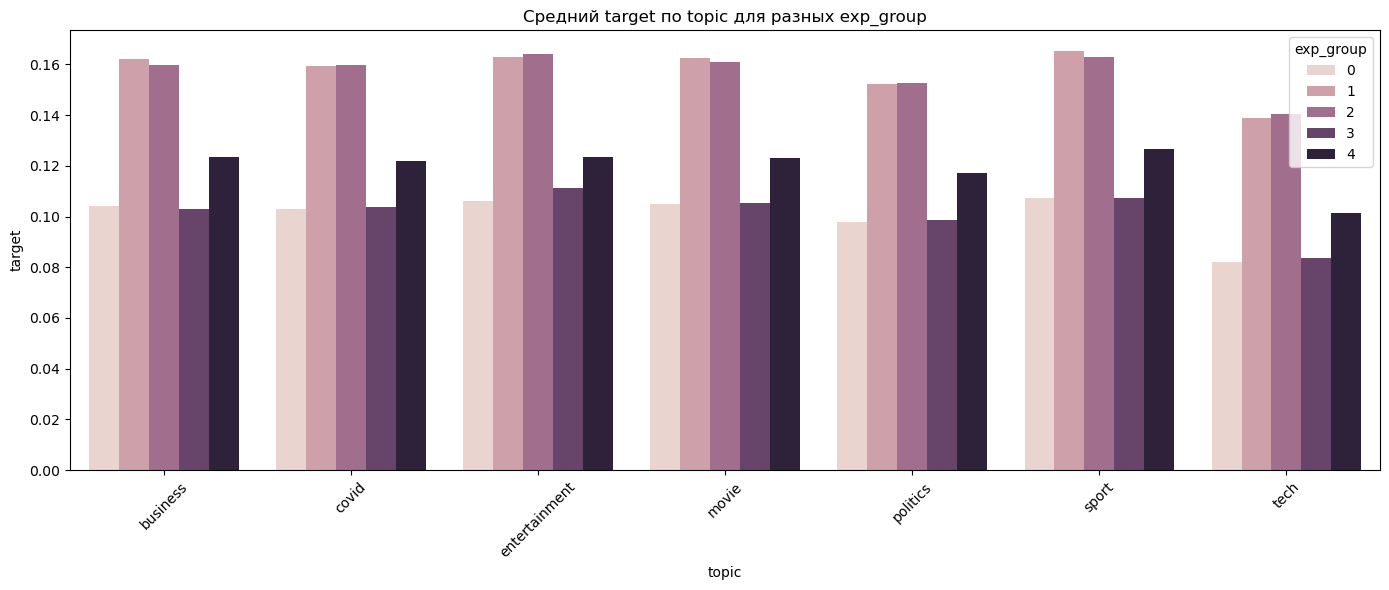

In [16]:
plt.figure(figsize=(14, 6))
sns.barplot(data=grouped, x='topic', y='target', hue='exp_group')
plt.title('Средний target по topic для разных exp_group')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


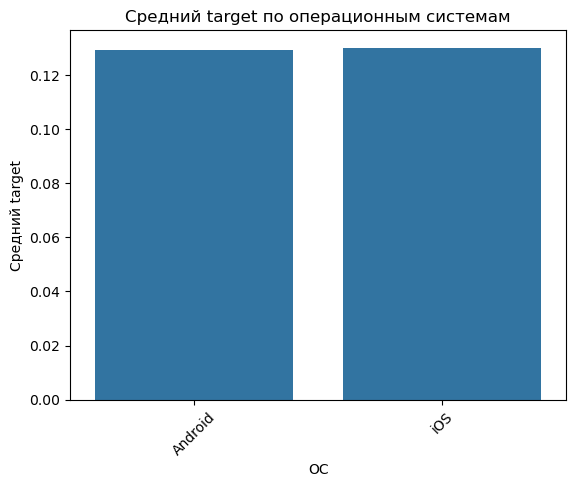

In [18]:
df = df3.merge(df1[['user_id', 'os']], on='user_id', how='inner')
df.groupby('os')['target'].mean().sort_values(ascending=False)
import seaborn as sns
import matplotlib.pyplot as plt

os_target = df.groupby('os')['target'].mean().reset_index()
sns.barplot(data=os_target, x='os', y='target')
plt.title('Средний target по операционным системам')
plt.ylabel('Средний target')
plt.xlabel('ОС')
plt.xticks(rotation=45)
plt.show()



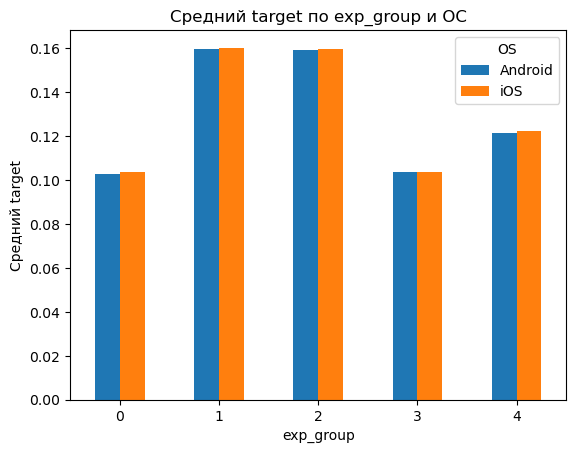

In [19]:
df = df3.merge(df1[['user_id', 'os', 'exp_group']], on='user_id', how='inner')

group_os_target = df.groupby(['exp_group', 'os'])['target'].mean().unstack()
group_os_target.plot(kind='bar')
plt.title('Средний target по exp_group и ОС')
plt.ylabel('Средний target')
plt.xlabel('exp_group')
plt.legend(title='OS')
plt.xticks(rotation=0)
plt.show()


In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

os_target = df.groupby('os')['target'].mean().reset_index()
sns.barplot(data=os_target, x='os', y='target')
plt.title('Средний таргет по операционным системам')
plt.ylabel('Средний target')
plt.xlabel('Операционная система')
plt.xticks(rotation=45)
plt.show()


NameError: name 'df' is not defined

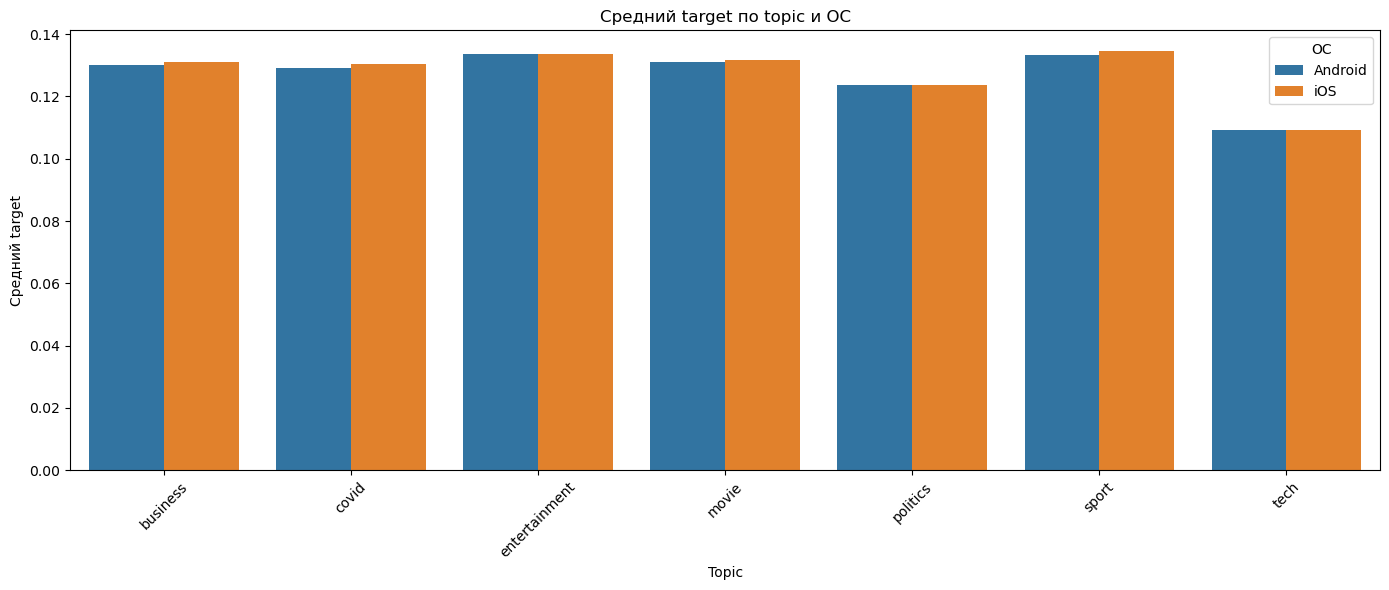

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Объединяем feed_data с user_data
df = df3.merge(df1[['user_id', 'os']], on='user_id', how='inner')

# Добавляем topic из постов
df = df.merge(df2[['post_id', 'topic']], on='post_id', how='inner')

# Группируем по os и topic и считаем средний target
os_topic_target = df.groupby(['os', 'topic'])['target'].mean().reset_index()

# Строим график
plt.figure(figsize=(14, 6))
sns.barplot(data=os_topic_target, x='topic', y='target', hue='os')
plt.title('Средний target по topic и ОС')
plt.ylabel('Средний target')
plt.xlabel('Topic')
plt.xticks(rotation=45)
plt.legend(title='ОС')
plt.tight_layout()
plt.show()


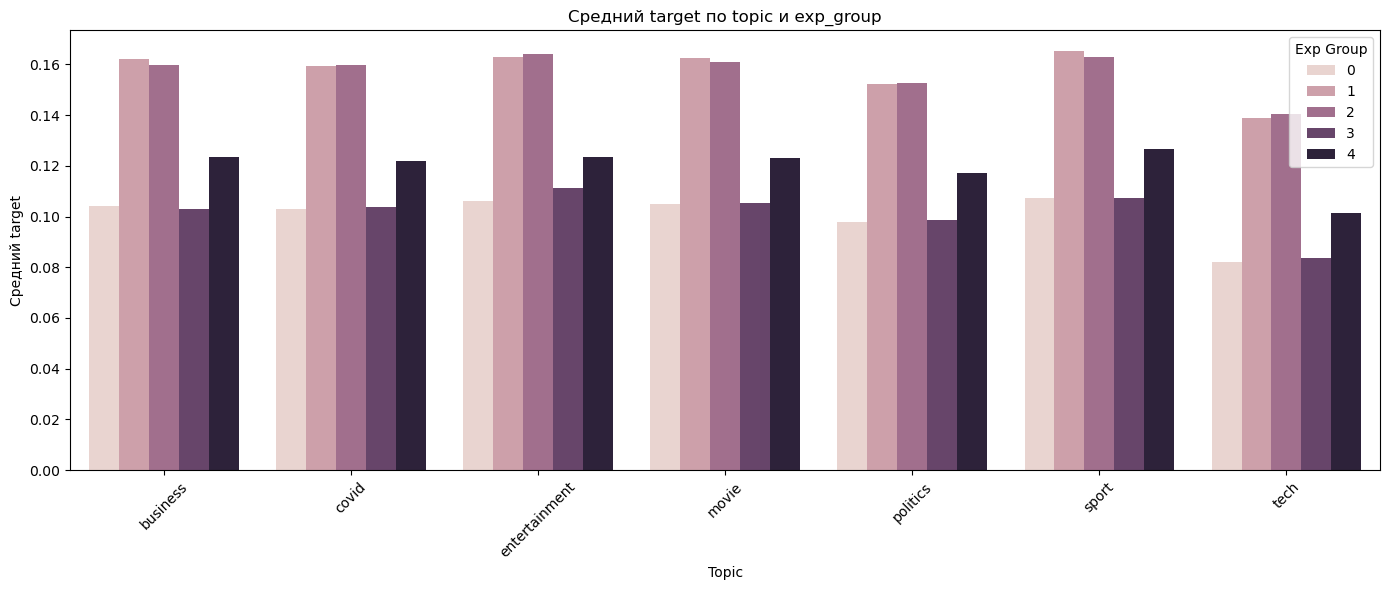

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Объединяем feed_data с user_data (exp_group)
df = df3.merge(df1[['user_id', 'exp_group']], on='user_id', how='inner')

# Добавляем topic из df2
df = df.merge(df2[['post_id', 'topic']], on='post_id', how='inner')

# Группируем по exp_group и topic, считаем средний таргет
grouped = df.groupby(['exp_group', 'topic'])['target'].mean().reset_index()

# Строим график
plt.figure(figsize=(14, 6))
sns.barplot(data=grouped, x='topic', y='target', hue='exp_group')
plt.title('Средний target по topic и exp_group')
plt.ylabel('Средний target')
plt.xlabel('Topic')
plt.xticks(rotation=45)
plt.legend(title='Exp Group')
plt.tight_layout()
plt.show()


In [ ]:
df = df3.merge(df1, on='user_id', how='left').merge(df2, on='post_id', how='left')
grouped = df.groupby(['topic', 'source'])['target'].mean().reset_index()
df = df3.merge(df2[['post_id', 'topic']], on='post_id', how='inner')

In [25]:
df = df3.merge(df2[['post_id', 'topic']], on='post_id', how='inner')


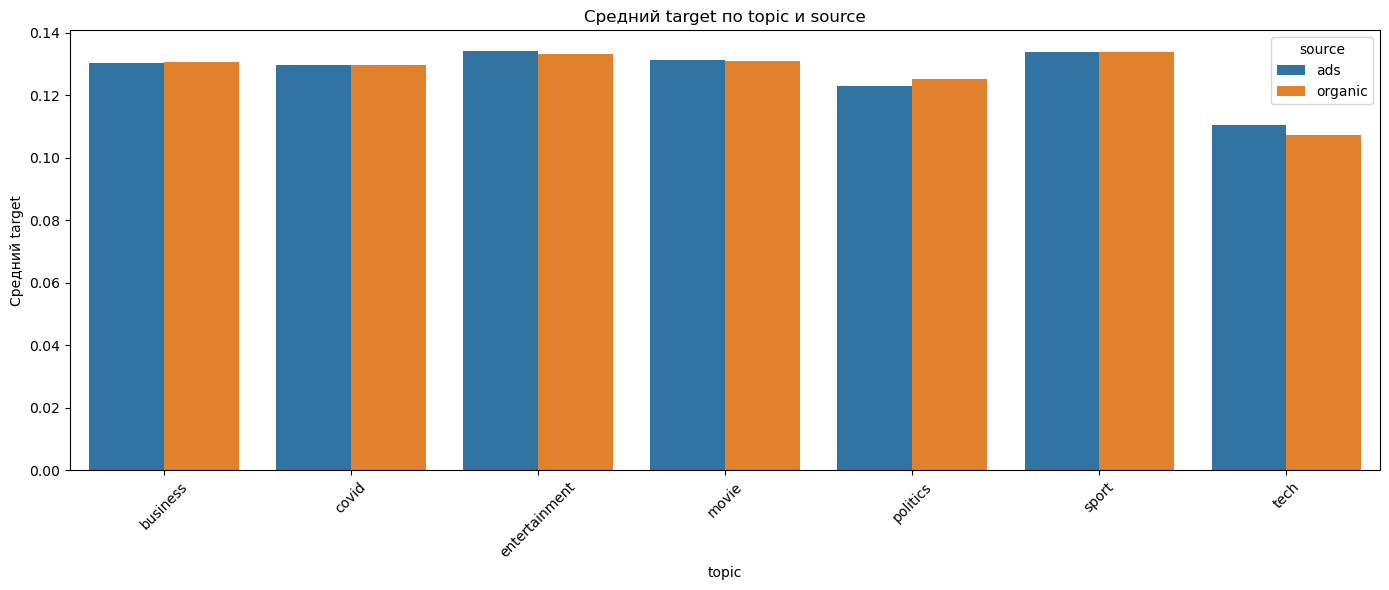

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
sns.barplot(data=grouped, x='topic', y='target', hue='source')
plt.title('Средний target по topic и source')
plt.ylabel('Средний target')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [30]:
likes_per_post = df3[df3['target'] == 1].groupby('post_id').size().reset_index(name='like_count')

In [31]:


posts_with_likes = df2.merge(likes_per_post, on='post_id', how='left')
posts_with_likes['like_count'] = posts_with_likes['like_count'].fillna(0).astype(int)


In [37]:
df2

,post_id,text,topic,like_count
0,1,UK economy facing major risks\n\nThe UK manufa...,business,84
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,58
2,3,Asian quake hits European shares\n\nShares in ...,business,86
3,4,India power shares jump on debut\n\nShares in ...,business,104
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,88
...,...,...,...,...
7018,7315,"OK, I would not normally watch a Farrelly brot...",movie,192
7019,7316,I give this movie 2 stars purely because of it...,movie,52
7020,7317,I cant believe this film was allowed to be mad...,movie,63
7021,7318,The version I saw of this film was the Blockbu...,movie,65


In [34]:
likes_per_post = df3[df3['target'] == 1].groupby('post_id').size().reset_index(name='like_count')


In [36]:
df2 = df2.merge(likes_per_post, left_on='post_id', right_on='post_id', how='left')
df2['like_count'] = df2['like_count'].fillna(0).astype(int)


In [47]:
# Группируем по post_id
ctr_per_post = df3.groupby('post_id').agg(
    views=('target', 'count'),              # всего просмотров
    likes=('target', 'sum')                 # всего лайков (target=1)
).reset_index()

# Вычисляем CTR
ctr_per_post['ctr'] = ctr_per_post['likes'] / ctr_per_post['views']

# Присоединяем к df2 (таблице постов)
df2 = df2.merge(ctr_per_post, left_on='post_id', right_on='post_id', how='left')


In [41]:
df21

,post_id,text,topic,like_count,views,likes,ctr
0,1,UK economy facing major risks\n\nThe UK manufa...,business,84,617.0,84.0,0.136143
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,58,549.0,58.0,0.105647
2,3,Asian quake hits European shares\n\nShares in ...,business,86,575.0,86.0,0.149565
3,4,India power shares jump on debut\n\nShares in ...,business,104,590.0,104.0,0.176271
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,88,589.0,88.0,0.149406
...,...,...,...,...,...,...,...
7018,7315,"OK, I would not normally watch a Farrelly brot...",movie,192,1145.0,192.0,0.167686
7019,7316,I give this movie 2 stars purely because of it...,movie,52,469.0,52.0,0.110874
7020,7317,I cant believe this film was allowed to be mad...,movie,63,502.0,63.0,0.125498
7021,7318,The version I saw of this film was the Blockbu...,movie,65,484.0,65.0,0.134298


In [42]:
# Считаем длину текста
df2['text_len'] = df2['text'].str.len()

# Считаем пороги
len_33 = df2['text_len'].quantile(0.33)
len_66 = df2['text_len'].quantile(0.66)

# Присваиваем категории
def text_length_category(length):
    if length <= len_33:
        return 'short'
    elif length <= len_66:
        return 'medium'
    else:
        return 'long'

df2['text_length_group'] = df2['text_len'].apply(text_length_category)


In [48]:
df2

,post_id,text,topic,like_count,text_len,text_length_group,views,likes,ctr
0,1,UK economy facing major risks\n\nThe UK manufa...,business,84,1967,long,617.0,84.0,0.136143
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,58,2701,long,549.0,58.0,0.105647
2,3,Asian quake hits European shares\n\nShares in ...,business,86,3408,long,575.0,86.0,0.149565
3,4,India power shares jump on debut\n\nShares in ...,business,104,1026,medium,590.0,104.0,0.176271
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,88,889,medium,589.0,88.0,0.149406
...,...,...,...,...,...,...,...,...,...
7018,7315,"OK, I would not normally watch a Farrelly brot...",movie,192,803,medium,1145.0,192.0,0.167686
7019,7316,I give this movie 2 stars purely because of it...,movie,52,800,medium,469.0,52.0,0.110874
7020,7317,I cant believe this film was allowed to be mad...,movie,63,636,medium,502.0,63.0,0.125498
7021,7318,The version I saw of this film was the Blockbu...,movie,65,728,medium,484.0,65.0,0.134298


In [45]:
# Функция для безопасной загрузки данных с чанкованием
def load_table_with_missing_stats(table_name, chunksize=50000):
    total_missing = {}
    chunks = [df1,df2,df3]
    for chunk in chunks:
        chunk_missing = chunk.isna().sum().to_dict()
        for col, count in chunk_missing.items():
            total_missing[col] = total_missing.get(col, 0) + count
            
    return pd.Series(total_missing, name=table_name)

In [46]:
# Собираем статистику для всех таблиц
tables = ["user_data", "post_text_df", "feed_data"]
missing_stats = {}

for table in tables:
    print(f"Анализируем таблицу {table}...")
    missing_stats[table] = load_table_with_missing_stats(table)

# Выводим результаты
for table, stats in missing_stats.items():
    print(f"\nТаблица: {table.upper()}")
    print("Пропуски по колонкам:")
    print(stats.to_string())
    print(f"Всего пропусков: {stats.sum()}")

Анализируем таблицу user_data...
Анализируем таблицу post_text_df...
Анализируем таблицу feed_data...

Таблица: USER_DATA
Пропуски по колонкам:
user_id              0
gender               0
age                  0
country              0
city                 0
exp_group            0
os                   0
source               0
post_id              0
text                 0
topic                0
like_count           0
text_len             0
text_length_group    0
timestamp            0
action               0
target               0
rn                   0
Всего пропусков: 0

Таблица: POST_TEXT_DF
Пропуски по колонкам:
user_id              0
gender               0
age                  0
country              0
city                 0
exp_group            0
os                   0
source               0
post_id              0
text                 0
topic                0
like_count           0
text_len             0
text_length_group    0
timestamp            0
action               0
target    

In [53]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix
import re

In [54]:

# Предположим, у вас есть DataFrame с данными
data = pd.DataFrame({
    'post_id': df2['post_id'],
    'text': df2['text'],
    'ctr': df2['ctr']
})

# 1. Предобработка текста
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Удаляем пунктуацию
    return text

data['text_clean'] = data['text'].apply(preprocess_text)

# 2. TF-IDF векторизация
tfidf = TfidfVectorizer(
    max_features=100,
    ngram_range=(1, 2),
    stop_words=['как', 'для', 'на']
)

# 3. Преобразование в CSR-формат сразу
tfidf_features = tfidf.fit_transform(data['text_clean']).tocsr()

# 4. Добавление CTR (преобразуем в sparse-матрицу)
ctr_features = csr_matrix(data['ctr'].values.reshape(-1, 1))

# 5. Объединение фичей
final_features = hstack([tfidf_features, ctr_features]).tocsr()

# Проверка результата
print("Размерность фичей:", final_features.shape)
print("\nПример фичей для первого поста:")
print(final_features[0].toarray())  # Теперь работает!

Размерность фичей: (7023, 101)

Пример фичей для первого поста:
[[0.         0.         0.         0.04707019 0.03971582 0.26160943
  0.0471528  0.03673182 0.03472346 0.07239223 0.05218988 0.
  0.         0.04592688 0.03397968 0.         0.         0.
  0.         0.         0.         0.         0.12125983 0.09773144
  0.03879838 0.         0.         0.09298155 0.03771992 0.03588475
  0.         0.         0.         0.         0.26867867 0.10754525
  0.         0.08513501 0.12174507 0.05391441 0.         0.
  0.         0.         0.         0.         0.04548255 0.
  0.         0.         0.         0.         0.         0.23336295
  0.         0.06416074 0.         0.         0.         0.
  0.         0.         0.21721228 0.         0.18504567 0.
  0.         0.         0.04856485 0.04972474 0.06216491 0.70931687
  0.09501512 0.         0.04657114 0.         0.         0.
  0.         0.23116563 0.         0.         0.05513278 0.09132989
  0.         0.         0.03450663 0.   

In [80]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Предполагается, что df2 уже загружен и содержит колонку 'text'
# Заполняем пропуски
texts = df2['text'].fillna('').tolist()

# 1) Вычисляем TF–IDF
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(texts)  # разреженная матрица (n_docs × n_features)

# 2) Берём вектор IDF
idf = vectorizer.idf_  # массив длины n_features



# 4) Считаем среднее значение по каждой строке (по документу)
mean_tfidf_idf = np.asarray(X_tfidf.mean(axis=1)).ravel()

# 5) Добавляем признак в df2
df2['mean_tfidf_idf'] = mean_tfidf_idf

# Теперь в df2 есть новая колонка 'mean_tfidf_idf' с нужным значением для каждого текста


In [93]:
df2

,post_id,text,topic,like_count,text_length_group,views,ctr,mean_tfidf_scaled
0,1,UK economy facing major risks\n\nThe UK manufa...,business,84,long,617.0,0.136143,0.627607
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,58,long,549.0,0.105647,1.492879
2,3,Asian quake hits European shares\n\nShares in ...,business,86,long,575.0,0.149565,1.700723
3,4,India power shares jump on debut\n\nShares in ...,business,104,medium,590.0,0.176271,-0.162525
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,88,medium,589.0,0.149406,-0.219965
...,...,...,...,...,...,...,...,...
7018,7315,"OK, I would not normally watch a Farrelly brot...",movie,192,medium,1145.0,0.167686,0.074167
7019,7316,I give this movie 2 stars purely because of it...,movie,52,medium,469.0,0.110874,0.128123
7020,7317,I cant believe this film was allowed to be mad...,movie,63,medium,502.0,0.125498,-0.342423
7021,7318,The version I saw of this film was the Blockbu...,movie,65,medium,484.0,0.134298,0.037629


In [84]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df2['mean_tfidf_scaled'] = scaler.fit_transform(df2[['mean_tfidf_idf']])


In [92]:
df2 = df2.drop(columns=['mean_tfidf_idf_scaled'])

In [103]:
df21 = df2.drop(columns=['text'])

In [104]:
df21 = pd.get_dummies(df21, drop_first=True)

In [105]:
df21

,post_id,like_count,views,ctr,mean_tfidf_scaled,topic_covid,topic_entertainment,topic_movie,topic_politics,topic_sport,topic_tech,text_length_group_medium,text_length_group_short
0,1,84,617.0,0.136143,0.627607,False,False,False,False,False,False,False,False
1,2,58,549.0,0.105647,1.492879,False,False,False,False,False,False,False,False
2,3,86,575.0,0.149565,1.700723,False,False,False,False,False,False,False,False
3,4,104,590.0,0.176271,-0.162525,False,False,False,False,False,False,True,False
4,5,88,589.0,0.149406,-0.219965,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7018,7315,192,1145.0,0.167686,0.074167,False,False,True,False,False,False,True,False
7019,7316,52,469.0,0.110874,0.128123,False,False,True,False,False,False,True,False
7020,7317,63,502.0,0.125498,-0.342423,False,False,True,False,False,False,True,False
7021,7318,65,484.0,0.134298,0.037629,False,False,True,False,False,False,True,False


In [139]:
df1

,user_id,gender,age,country,city,exp_group,os,source,age_group
0,200,1,34,Russia,Degtyarsk,3,Android,ads,34–45
1,201,0,37,Russia,Abakan,0,Android,ads,34–45
2,202,1,17,Russia,Smolensk,4,Android,ads,до 18
3,203,0,18,Russia,Moscow,1,iOS,ads,до 18
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads,34–45
...,...,...,...,...,...,...,...,...,...
163200,168548,0,36,Russia,Kaliningrad,4,Android,organic,34–45
163201,168549,0,18,Russia,Tula,2,Android,organic,до 18
163202,168550,1,41,Russia,Yekaterinburg,4,Android,organic,34–45
163203,168551,0,38,Russia,Moscow,3,iOS,organic,34–45


In [123]:
df1[(df1['age'] >33 ) & (df1['age'] <= 45)]['age'].describe()

count    28760.000000
mean        38.629207
std          3.360726
min         34.000000
25%         36.000000
50%         38.000000
75%         41.000000
max         45.000000
Name: age, dtype: float64

In [135]:
df11 = df1.copy()

In [137]:
bins = [0, 18, 24, 33, 45, float('inf')]
labels = ['до 18', '19–24', '25–33', '34–45', 'старше 45']

df11['age_group1'] = pd.cut(df11['age'], bins=bins, labels=labels, right=True, include_lowest=True)


In [141]:
df11 = df11.drop(columns=['age_group1'])

In [152]:
df11

,user_id,gender,age,country,city,exp_group,os,source,age_group
0,200,1,34,Russia,Degtyarsk,3,Android,ads,34–45
1,201,0,37,Russia,Abakan,0,Android,ads,34–45
2,202,1,17,Russia,Smolensk,4,Android,ads,до 18
3,203,0,18,Russia,Moscow,1,iOS,ads,до 18
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads,34–45
...,...,...,...,...,...,...,...,...,...
163200,168548,0,36,Russia,Kaliningrad,4,Android,organic,34–45
163201,168549,0,18,Russia,Tula,2,Android,organic,до 18
163202,168550,1,41,Russia,Yekaterinburg,4,Android,organic,34–45
163203,168551,0,38,Russia,Moscow,3,iOS,organic,34–45


In [187]:
ohe = pd.get_dummies(df11['country'], drop_first=True)

In [188]:
df_final = pd.concat([df11.drop('country', axis=1), ohe], axis=1)

In [189]:
df_final

,user_id,gender,age,city,exp_group,os,source,age_group,Belarus,Cyprus,Estonia,Finland,Kazakhstan,Latvia,Russia,Switzerland,Turkey,Ukraine
0,200,1,34,Degtyarsk,3,Android,ads,34–45,False,False,False,False,False,False,True,False,False,False
1,201,0,37,Abakan,0,Android,ads,34–45,False,False,False,False,False,False,True,False,False,False
2,202,1,17,Smolensk,4,Android,ads,до 18,False,False,False,False,False,False,True,False,False,False
3,203,0,18,Moscow,1,iOS,ads,до 18,False,False,False,False,False,False,True,False,False,False
4,204,0,36,Anzhero-Sudzhensk,3,Android,ads,34–45,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163200,168548,0,36,Kaliningrad,4,Android,organic,34–45,False,False,False,False,False,False,True,False,False,False
163201,168549,0,18,Tula,2,Android,organic,до 18,False,False,False,False,False,False,True,False,False,False
163202,168550,1,41,Yekaterinburg,4,Android,organic,34–45,False,False,False,False,False,False,True,False,False,False
163203,168551,0,38,Moscow,3,iOS,organic,34–45,False,False,False,False,False,False,True,False,False,False


In [160]:
feed_merged = df3.merge(df1[['user_id', 'city']], on='user_id', how='left')
city_stats = (
    feed_merged
    .groupby('city')
    .agg(
        city_views=('target', 'count'),
        city_ctr=('target', 'mean')
    )
    .reset_index()
)

# Глобальный CTR
global_ctr = feed_merged['target'].mean()

# Сглаживание
m = 100  # можно варьировать
city_stats['city_te'] = (
    (city_stats['city_views'] * city_stats['city_ctr'] + m * global_ctr) /
    (city_stats['city_views'] + m)
)


In [162]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Предположим, у тебя есть df_merged — объединённая таблица с city и target
# И она уже содержит все нужные поля (df1, df2, df3 объединены)

def target_encode_smooth(df, col, target, m):
    global_mean = df[target].mean()
    agg = df.groupby(col)[target].agg(['mean', 'count'])
    smooth = (agg['count'] * agg['mean'] + m * global_mean) / (agg['count'] + m)
    return df[col].map(smooth)

def evaluate_smoothing(df, col, target, m, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = []

    for train_idx, val_idx in kf.split(df):
        train, val = df.iloc[train_idx].copy(), df.iloc[val_idx].copy()

        # Считаем encoding на трейне
        global_mean = train[target].mean()
        agg = train.groupby(col)[target].agg(['mean', 'count'])
        smooth = (agg['count'] * agg['mean'] + m * global_mean) / (agg['count'] + m)

        train['encoded'] = train[col].map(smooth).fillna(global_mean)
        val['encoded'] = val[col].map(smooth).fillna(global_mean)

        # Обучаем на train, предсказываем на val
        model = LogisticRegression()
        model.fit(train[['encoded']], train[target])
        preds = model.predict_proba(val[['encoded']])[:, 1]

        score = roc_auc_score(val[target], preds)
        scores.append(score)

    return np.mean(scores)


# Подберем m
m_values = [1, 5, 10, 20, 50, 100, 200, 500]
results = {m: evaluate_smoothing(feed_merged, 'city', 'target', m) for m in m_values}

# Выведем результат
best_m = max(results, key=results.get)
print(f"Лучшее значение m: {best_m} с AUC: {results[best_m]:.4f}")


Лучшее значение m: 20 с AUC: 0.6109


In [ ]:
# Построим финальный encoding на всём df
global_mean = df[target].mean()
agg = df.groupby('city')[target].agg(['mean', 'count'])
smooth = (agg['count'] * agg['mean'] + 20 * global_mean) / (agg['count'] + 20)
df['city_te'] = df['city'].map(smooth).fillna(global_mean)


In [190]:
# Шаг 1: Объединяем df3 с df1, чтобы у каждой записи с target был город
df_temp = df3.merge(df1[['user_id', 'city']], on='user_id', how='left')

# Шаг 2: Считаем сглаженный target encoding
def compute_target_encoding(df, target_col, cat_col, m):
    global_mean = df[target_col].mean()
    agg = df.groupby(cat_col)[target_col].agg(['mean', 'count'])
    smooth = (agg['count'] * agg['mean'] + m * global_mean) / (agg['count'] + m)
    return smooth

m = 20  # Сглаживание
city_te_series = compute_target_encoding(df_temp, target_col='target', cat_col='city', m=m)

# Шаг 3: Присоединяем результат обратно к df1
df_final['city_te'] = df1['city'].map(city_te_series).fillna(df_temp['target'].mean())


In [211]:
df_final

,user_id,Belarus,Cyprus,Estonia,Finland,Kazakhstan,Latvia,Russia,Switzerland,Turkey,...,19–24,25–33,34–45,старше 45,1,2,3,4,iOS,organic
0,200,False,False,False,False,False,False,True,False,False,...,False,False,True,False,False,False,True,False,False,False
1,201,False,False,False,False,False,False,True,False,False,...,False,False,True,False,False,False,False,False,False,False
2,202,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
3,203,False,False,False,False,False,False,True,False,False,...,False,False,False,False,True,False,False,False,True,False
4,204,False,False,False,False,False,False,True,False,False,...,False,False,True,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163200,168548,False,False,False,False,False,False,True,False,False,...,False,False,True,False,False,False,False,True,False,True
163201,168549,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,True,False,False,False,True
163202,168550,False,False,False,False,False,False,True,False,False,...,False,False,True,False,False,False,False,True,False,True
163203,168551,False,False,False,False,False,False,True,False,False,...,False,False,True,False,False,False,True,False,True,True


In [209]:
ohe = pd.get_dummies(df_final['source'], drop_first=True)

In [210]:
df_final = pd.concat([df_final.drop('source', axis=1), ohe], axis=1)

In [200]:
df_final = df_final.drop('city', axis=1)

In [212]:
df3_final = df_final.copy()

In [ ]:
num_cols = df.select_dtypes(exclude='object').columns


In [213]:
df21

,post_id,like_count,views,ctr,mean_tfidf_scaled,topic_covid,topic_entertainment,topic_movie,topic_politics,topic_sport,topic_tech,text_length_group_medium,text_length_group_short
0,1,84,617.0,0.136143,0.627607,False,False,False,False,False,False,False,False
1,2,58,549.0,0.105647,1.492879,False,False,False,False,False,False,False,False
2,3,86,575.0,0.149565,1.700723,False,False,False,False,False,False,False,False
3,4,104,590.0,0.176271,-0.162525,False,False,False,False,False,False,True,False
4,5,88,589.0,0.149406,-0.219965,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7018,7315,192,1145.0,0.167686,0.074167,False,False,True,False,False,False,True,False
7019,7316,52,469.0,0.110874,0.128123,False,False,True,False,False,False,True,False
7020,7317,63,502.0,0.125498,-0.342423,False,False,True,False,False,False,True,False
7021,7318,65,484.0,0.134298,0.037629,False,False,True,False,False,False,True,False


In [224]:
df3

,user_id,post_id,target
0,200,1773,0
1,200,2213,1
2,200,1122,0
3,200,1362,0
4,200,1541,0
...,...,...,...
4896145,168552,4284,0
4896146,168552,5487,1
4896147,168552,1966,0
4896148,168552,6107,0


In [ ]:
df3['action']

In [223]:
df3 = df3.drop('timestamp', axis=1)

In [215]:
df_final.to_csv('df1.csv', index=False)
df21.to_csv('df2.csv', index=False)



In [220]:
df3.to_csv('df3.csv', index=False)

In [226]:
# Объединяем df3 с df1 по post_id
merged = df3.merge(df_final, on='user_id', how='left')

# Затем объединяем с df2 по user_id
merged = merged.merge(df21, on='post_id', how='left')



In [227]:
merged

,user_id,post_id,target,Belarus,Cyprus,Estonia,Finland,Kazakhstan,Latvia,Russia,...,ctr,mean_tfidf_scaled,topic_covid,topic_entertainment,topic_movie,topic_politics,topic_sport,topic_tech,text_length_group_medium,text_length_group_short
0,200,1773,0,False,False,False,False,False,False,True,...,0.147453,0.841116,False,False,False,False,True,False,False,False
1,200,2213,1,False,False,False,False,False,False,True,...,0.109187,0.334638,False,False,False,False,False,True,False,False
2,200,1122,0,False,False,False,False,False,False,True,...,0.146624,0.454193,False,False,False,True,False,False,False,False
3,200,1362,0,False,False,False,False,False,False,True,...,0.104197,0.721488,False,False,False,True,False,False,False,False
4,200,1541,0,False,False,False,False,False,False,True,...,0.141100,1.209895,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4896145,168552,4284,0,False,False,False,False,False,False,True,...,0.171975,2.128995,False,False,True,False,False,False,False,False
4896146,168552,5487,1,False,False,False,False,False,False,True,...,0.084507,-0.409243,False,False,True,False,False,False,True,False
4896147,168552,1966,0,False,False,False,False,False,False,True,...,0.120939,1.691602,False,False,False,False,False,True,False,False
4896148,168552,6107,0,False,False,False,False,False,False,True,...,0.125000,0.236265,False,False,True,False,False,False,True,False


In [228]:
merged.to_csv('merged.csv', index=False)

In [234]:
merged.head(3000000).to_csv('merged3000000.csv', index=False)

In [232]:
print(merged.dtypes)


user_id                       int64
post_id                       int64
target                        int64
Belarus                        bool
Cyprus                         bool
Estonia                        bool
Finland                        bool
Kazakhstan                     bool
Latvia                         bool
Russia                         bool
Switzerland                    bool
Turkey                         bool
Ukraine                        bool
city_te                     float64
1                              bool
19–24                          bool
25–33                          bool
34–45                          bool
старше 45                      bool
1                              bool
2                              bool
3                              bool
4                              bool
iOS                            bool
organic                        bool
like_count                    int32
views                       float64
ctr                         

In [244]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Метрика HitRate@5
def hit_rate_at5(model, X, y_true, user_ids):
    proba = model.predict_proba(X)[:, 1]
    results = pd.DataFrame({
        'user_id': user_ids.values,
        'proba': proba,
        'target': y_true.values
    })
    top5 = results.groupby('user_id').apply(lambda x: x.nlargest(5, 'proba')).reset_index(drop=True)
    return top5.groupby('user_id')['target'].max().mean()

# 1. Загрузка и подготовка данных
print("Загрузка данных...")
df = pd.read_csv('merged1000000.csv', low_memory=False)

# Обработка целевой переменной
df = df[df['target'].notna()]  # Удаление NaN
df = df[df['target'].isin([0, 1])]  # Оставляем только 0 и 1

# 2. Создание новых признаков
print("\nСоздание новых признаков...")

# Комбинированные фичи
df['ctr_tfidf_interaction'] = df['ctr'] * df['mean_tfidf_scaled']
df['views_per_like'] = df['views'] / (df['like_count'] + 1e-5)

# Групповые статистики по пользователям
user_stats = df.groupby('user_id').agg({
    'like_count': ['mean', 'sum'],
    'views': ['mean', 'max']
})
user_stats.columns = [f'user_{col[0]}_{col[1]}' for col in user_stats.columns]
df = df.join(user_stats, on='user_id')

# Взаимодействие тем с источником трафика
for topic in ['covid', 'entertainment', 'sport', 'tech']:
    if f'topic_{topic}' in df.columns and 'organic' in df.columns:
        df[f'topic_{topic}_organic'] = df[f'topic_{topic}'] & df['organic']

# 3. Подготовка данных для модели
X = df.drop(['user_id', 'post_id', 'target'], axis=1, errors='ignore')
y = df['target']
user_ids = df['user_id']

# Категориальные признаки
bool_cols = [col for col in X.columns if X[col].dtype == 'bool']
for col in bool_cols:
    X[col] = X[col].astype(int)

# Разделение данных
X_train, X_test, y_train, y_test, uid_train, uid_test = train_test_split(
    X, y, user_ids, test_size=0.2, random_state=42, stratify=y
)

# 4. Параметры моделей
catboost_params = {
    'iterations': 2000,
    'learning_rate': 0.035,
    'depth': 8,
    'l2_leaf_reg': 5,
    'border_count': 254,
    'random_strength': 0.5,
    'bootstrap_type': 'Bayesian',
    'od_type': 'Iter',
    'od_wait': 150,
    'eval_metric': 'AUC',
    'loss_function': 'Logloss',
    'verbose': 100,
    'random_seed': 42,
    'auto_class_weights': 'Balanced',
    'thread_count': -1
}

xgb_params = {
    'max_depth': 6,
    'learning_rate': 0.04,
    'n_estimators': 1000,
    'subsample': 0.8,
    'colsample_bytree': 0.9,
    'random_state': 42,
    'eval_metric': 'auc',
    'tree_method': 'gpu_hist'  # Убирай, если нет GPU
}

# 5. Обучение базовых моделей
print("\nОбучение CatBoost...")
cat_model = CatBoostClassifier(**catboost_params)
cat_model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    early_stopping_rounds=100
)

print("\nОбучение XGBoost...")
from xgboost.callback import EarlyStopping

xgb_model = XGBClassifier(**xgb_params)
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    callbacks=[EarlyStopping(rounds=100, save_best=True)],
    verbose=100
)


# 6. Ансамбль VotingClassifier
print("\nФормирование ансамбля...")
ensemble = VotingClassifier(
    estimators=[('cat', cat_model), ('xgb', xgb_model)],
    voting='soft',
    n_jobs=-1
)

ensemble.fit(X_train, y_train)  # Просто объединяет предобученные модели

# 7. Подбор оптимального порога
print("\nОптимизация порога...")
best_threshold = 0.5
best_score = 0

y_proba = ensemble.predict_proba(X_test)[:, 1]

for threshold in np.linspace(0.3, 0.7, 50):
    y_pred = (y_proba > threshold).astype(int)
    current_score = hit_rate_at5(ensemble, X_test, y_test, uid_test)
    
    if current_score > best_score:
        best_score = current_score
        best_threshold = threshold

print(f"Лучший порог: {best_threshold:.3f}, HitRate@5: {best_score:.4f}")

# 8. Финальное обучение CatBoost на всех данных
print("\nФинализация модели...")
final_model = CatBoostClassifier(**catboost_params)
final_model.fit(
    Pool(X, y, cat_features=bool_cols),
    early_stopping_rounds=150,
    use_best_model=True
)

# 9. Сохранение модели
final_model.save_model('improved_catboost_model.cbm')
print("\nФинальная модель сохранена в improved_catboost_model.cbm")
print(f"Final Test HitRate@5: {best_score:.4f}")


Загрузка данных...

Создание новых признаков...

Обучение CatBoost...
0:	test: 0.6718260	best: 0.6718260 (0)	total: 93.2ms	remaining: 3m 6s
100:	test: 0.6999621	best: 0.6999621 (100)	total: 9.24s	remaining: 2m 53s
200:	test: 0.7032825	best: 0.7032825 (200)	total: 17.7s	remaining: 2m 38s
300:	test: 0.7043693	best: 0.7043693 (300)	total: 25.7s	remaining: 2m 25s
400:	test: 0.7048002	best: 0.7048002 (400)	total: 33.6s	remaining: 2m 14s
500:	test: 0.7049694	best: 0.7049760 (489)	total: 41.7s	remaining: 2m 4s
600:	test: 0.7050444	best: 0.7050659 (587)	total: 49.6s	remaining: 1m 55s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7050659047
bestIteration = 587

Shrink model to first 588 iterations.

Обучение XGBoost...


TypeError: XGBClassifier.fit() got an unexpected keyword argument 'callbacks'

In [249]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

def hit_rate_at5(model, X, y_true, user_ids):
    proba = model.predict_proba(X)[:, 1]
    results = pd.DataFrame({
        'user_id': user_ids.values,
        'proba': proba,
        'target': y_true.values
    })
    # Группировка по user_id и отбор топ-5 по вероятности
    top5 = results.groupby('user_id').apply(lambda x: x.nlargest(5, 'proba')).reset_index(drop=True)
    # Считаем HitRate@5, если хотя бы 1 пост в топ-5 имеет метку 1 (пользователь поставил лайк)
    return top5.groupby('user_id')['target'].max().mean()

# 1. Загрузка данных
print("Загрузка данных...")
df = pd.read_csv('merged.csv', low_memory=False)

# Обработка целевой переменной
df = df[df['target'].isin([0, 1])]  # Фикс KeyError

# 2. Создание новых признаков
print("\nСоздание новых признаков...")

df['ctr_tfidf_interaction'] = df['ctr'] * df['mean_tfidf_scaled']
df['views_per_like'] = df['views'] / (df['like_count'] + 1e-5)

user_stats = df.groupby('user_id').agg({
    'like_count': ['mean', 'sum'],
    'views': ['mean', 'max']
})
user_stats.columns = [f'user_{col[0]}_{col[1]}' for col in user_stats.columns]
df = df.join(user_stats, on='user_id')

for topic in ['covid', 'entertainment', 'sport', 'tech']:
    df[f'topic_{topic}_organic'] = df[f'topic_{topic}'] & df['organic']

# 3. Подготовка данных
X = df.drop(['user_id', 'post_id', 'target'], axis=1, errors='ignore')
y = df['target']
user_ids = df['user_id']

bool_cols = [col for col in X.columns if X[col].dtype == 'bool']
X[bool_cols] = X[bool_cols].astype(int)

X_train, X_test, y_train, y_test, uid_train, uid_test = train_test_split(
    X, y, user_ids, test_size=0.2, random_state=42, stratify=y
)

# 4. CatBoost модель
print("\nОбучение CatBoost...")
catboost_params = {
    'iterations': 300,
    'learning_rate': 0.035,
    'depth': 8,
    'l2_leaf_reg': 5,
    'border_count': 254,
    'random_strength': 0.5,
    'bootstrap_type': 'Bayesian',
    'od_type': 'Iter',
    'od_wait': 150,
    'eval_metric': 'AUC',
    'loss_function': 'Logloss',
    'verbose': 100,
    'random_seed': 42,
    'auto_class_weights': 'Balanced',
    'thread_count': -1
}

cat_model = CatBoostClassifier(**catboost_params)
cat_model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    early_stopping_rounds=50
)

# 5. XGBoost модель (без early_stopping_rounds)
print("\nОбучение XGBoost...")
xgb_params = {
    'max_depth': 6,
    'learning_rate': 0.04,
    'n_estimators': 300,  # уменьшено, т.к. без early_stopping
    'subsample': 0.8,
    'colsample_bytree': 0.9,
    'random_state': 42,
    'eval_metric': 'auc',
    'tree_method': 'gpu_hist'  # Уберите если нет GPU
}

xgb_model = XGBClassifier(**xgb_params)
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=50
)

# 6. Ансамбль VotingClassifier
print("\nФормирование ансамбля...")
ensemble = VotingClassifier(
    estimators=[('cat', cat_model), ('xgb', xgb_model)],
    voting='soft',
    n_jobs=-1
)
ensemble.fit(X_train, y_train)  # Без eval_set

# 7. Подбор порога по HitRate@5
print("\nОптимизация по HitRate@5...")

# Оценка HitRate@5 на тестовом наборе
hit_rate_score = hit_rate_at5(ensemble, X_test, y_test, uid_test)

print(f"HitRate@5 на тестовой выборке: {hit_rate_score:.4f}")

# 8. Финальное обучение модели (CatBoost)
print("\nФинализация модели...")
final_model = CatBoostClassifier(**catboost_params)
final_model.fit(
    Pool(X, y, cat_features=bool_cols),
    early_stopping_rounds=150,
    use_best_model=True
)
print(f"HitRate@5 на тестовой выборке: {hit_rate_score:.4f}")
final_model.save_model('improved_catboost_model.cbm')
print("\nФинальная модель сохранена в improved_catboost_model.cbm")
print(f"Final Test HitRate@5: {hit_rate_score:.4f}")


Загрузка данных...

Создание новых признаков...

Обучение CatBoost...
0:	test: 0.6719916	best: 0.6719916 (0)	total: 213ms	remaining: 1m 3s
100:	test: 0.6988461	best: 0.6988461 (100)	total: 20.2s	remaining: 39.8s
200:	test: 0.7028303	best: 0.7028303 (200)	total: 41.1s	remaining: 20.2s
299:	test: 0.7042197	best: 0.7042197 (299)	total: 1m 1s	remaining: 0us

bestTest = 0.7042196757
bestIteration = 299


Обучение XGBoost...


c:\Users\Vlad\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:26:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)


[0]	validation_0-auc:0.65802
[50]	validation_0-auc:0.68449
[100]	validation_0-auc:0.68954
[150]	validation_0-auc:0.69694
[200]	validation_0-auc:0.70060
[250]	validation_0-auc:0.70244
[299]	validation_0-auc:0.70322

Формирование ансамбля...

Оптимизация по HitRate@5...


c:\Users\Vlad\anaconda3\Lib\site-packages\xgboost\core.py:2676: UserWarning: [15:27:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
C:\Users\Vlad\AppData\Local\Temp\ipykernel_14708\2535898193.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top5 = results.groupby('user_id').apply(lambda x: x.nlargest(5, 'proba')).reset_index(drop=True)


HitRate@5 на тестовой выборке: 0.4876

Финализация модели...


You should provide test set for use best model. use_best_model parameter has been switched to false value.


0:	total: 252ms	remaining: 1m 15s
100:	total: 24s	remaining: 47.3s
200:	total: 47.2s	remaining: 23.2s
299:	total: 1m 10s	remaining: 0us

Финальная модель сохранена в improved_catboost_model.cbm
Final Test HitRate@5: 0.4876


In [251]:
!pip install lightgbm 



   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 7.0 MB/s eta 0:00:00


In [253]:
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

# 2. Создание новых признаков
print("\nСоздание новых признаков...")
df['ctr_tfidf_interaction'] = df['ctr'] * df['mean_tfidf_scaled']
df['views_per_like'] = df['views'] / (df['like_count'] + 1e-5)

# Добавление новых признаков
df['like_to_view_ratio'] = df['like_count'] / (df['views'] + 1e-5)
df['ctr_per_user'] = df.groupby('user_id')['ctr'].transform('mean')

user_stats = df.groupby('user_id').agg({
    'like_count': ['mean', 'sum'],
    'views': ['mean', 'max']
})

# Изменяем имена столбцов для user_stats, чтобы избежать конфликта
user_stats.columns = [f'user_{col[0]}_{col[1]}' for col in user_stats.columns]

# Применяем join с добавлением суффиксов
df = df.join(user_stats, on='user_id', rsuffix='_user')

# Для каждого из topics добавляем новый признак
for topic in ['covid', 'entertainment', 'sport', 'tech']:
    df[f'topic_{topic}_organic'] = df[f'topic_{topic}'] & df['organic']

# 3. Подготовка данных
X = df.drop(['user_id', 'post_id', 'target'], axis=1, errors='ignore')
y = df['target']
user_ids = df['user_id']

# Преобразование столбцов с булевыми значениями в int
bool_cols = [col for col in X.columns if X[col].dtype == 'bool']
X[bool_cols] = X[bool_cols].astype(int)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test, uid_train, uid_test = train_test_split(
    X, y, user_ids, test_size=0.2, random_state=42, stratify=y
)

# Обучение моделей и оценка HitRate@5 (оставшуюся часть кода не изменяйте)


# 4. CatBoost модель
print("\nОбучение CatBoost...")
catboost_params = {
    'iterations': 150,  # Увеличение итераций
    'learning_rate': 0.03,  # Понижение learning rate
    'depth': 10,  # Более глубокие деревья
    'l2_leaf_reg': 3,  # Регуляризация
    'border_count': 128,
    'random_strength': 0.5,
    'bootstrap_type': 'Bayesian',
    'od_type': 'Iter',
    'od_wait': 150,
    'eval_metric': 'AUC',
    'loss_function': 'Logloss',
    'verbose': 100,
    'random_seed': 42,
    'auto_class_weights': 'Balanced',
    'thread_count': -1
}

cat_model = CatBoostClassifier(**catboost_params)
cat_model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    early_stopping_rounds=100
)

# 5. XGBoost модель (с улучшенной настройкой)
print("\nОбучение XGBoost...")
xgb_params = {
    'max_depth': 8,  # Увеличение глубины
    'learning_rate': 0.03,  # Уменьшение learning rate
    'n_estimators': 500,  # Увеличение количества деревьев
    'subsample': 0.9,  # Использование большего процента данных
    'colsample_bytree': 0.85,  # Использование чуть большего числа признаков
    'random_state': 42,
    'eval_metric': 'auc',
    'tree_method': 'gpu_hist'
}

xgb_model = XGBClassifier(**xgb_params)
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=100
)

# 6. Добавление LightGBM
lgbm_model = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.03,
    max_depth=8,
    subsample=0.9,
    colsample_bytree=0.85,
    random_state=42
)
lgbm_model.fit(X_train, y_train)

# 7. Ансамбль VotingClassifier
print("\nФормирование ансамбля с дополнительной моделью LightGBM...")
ensemble = VotingClassifier(
    estimators=[('cat', cat_model), ('xgb', xgb_model), ('lgbm', lgbm_model)],
    voting='soft',
    n_jobs=-1
)
ensemble.fit(X_train, y_train)  # Без eval_set

# 8. Оценка HitRate@5
print("\nОценка HitRate@5...")
hit_rate_score = hit_rate_at5(ensemble, X_test, y_test, uid_test)

print(f"Final Test HitRate@5: {hit_rate_score:.4f}")



Создание новых признаков...

Обучение CatBoost...
0:	test: 0.6840210	best: 0.6840210 (0)	total: 355ms	remaining: 52.9s
100:	test: 0.7018819	best: 0.7018819 (100)	total: 32.5s	remaining: 15.8s
149:	test: 0.7034543	best: 0.7034543 (149)	total: 48.3s	remaining: 0us

bestTest = 0.7034543214
bestIteration = 149


Обучение XGBoost...


c:\Users\Vlad\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:36:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)


[0]	validation_0-auc:0.67351
[100]	validation_0-auc:0.69754
[200]	validation_0-auc:0.70222
[300]	validation_0-auc:0.70440
[400]	validation_0-auc:0.70491
[499]	validation_0-auc:0.70502
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 507572, number of negative: 3409348
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090638 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4149
[LightGBM] [Info] Number of data points in the train set: 3916920, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.129584 -> initscore=-1.904638
[LightGBM] [Info] Start training from score -1.904638

Формирование ансамбля с дополнительной моделью LightGBM...

Оценка HitRate@5...


c:\Users\Vlad\anaconda3\Lib\site-packages\xgboost\core.py:2676: UserWarning: [15:38:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


Final Test HitRate@5: 0.4877


C:\Users\Vlad\AppData\Local\Temp\ipykernel_14708\2535898193.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top5 = results.groupby('user_id').apply(lambda x: x.nlargest(5, 'proba')).reset_index(drop=True)


In [254]:
import pickle

with open("improved_catboost_model.pkl", "wb") as f:
    pickle.dump(final_model, f)


In [255]:
import pandas as pd
from sqlalchemy import create_engine

# Подключение к БД
engine = create_engine(
    "postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
    "postgres.lab.karpov.courses:6432/startml"
)

# Ограничим объем (например, до 4 млн строк)
df_features = df.head(4_000_000)

# Название таблицы — по логину (предположим логин example@gmail.com)
table_name = "SivolapovVR_features_lesson_22"

# Сохранение признаков
df_features.to_sql(table_name, con=engine, index=False, if_exists="replace")


StatementError: (builtins.MemoryError) 
[SQL: INSERT INTO "SivolapovVR_features_lesson_22" (user_id, post_id, target, "Belarus", "Cyprus", "Estonia", "Finland", "Kazakhstan", "Latvia", "Russia", "Switzerland", "Turkey", "Ukraine", city_te, "1", "19–24", "25–33", "34–45", "старше 45", "1.1", "2", "3", "4", "iOS", organic, like_count, views, ctr, mean_tfidf_scaled, topic_covid, topic_entertainment, topic_movie, topic_politics, topic_sport, topic_tech, text_length_group_medium, text_length_group_short, ctr_tfidf_interaction, views_per_like, user_like_count_mean, user_like_count_sum, user_views_mean, user_views_max, topic_covid_organic, topic_entertainment_organic, topic_sport_organic, topic_tech_organic, like_to_view_ratio, ctr_per_user, user_like_count_mean_user, user_like_count_sum_user, user_views_mean_user, user_views_max_user) VALUES (%(user_id)s, %(post_id)s, %(target)s, %(Belarus)s, %(Cyprus)s, %(Estonia)s, %(Finland)s, %(Kazakhstan)s, %(Latvia)s, %(Russia)s, %(Switzerland)s, %(Turkey)s, %(Ukraine)s, %(city_te)s, %(1)s, %(19–24)s, %(25–33)s, %(34–45)s, %(старше_45)s, %(1_1)s, %(2)s, %(3)s, %(4)s, %(iOS)s, %(organic)s, %(like_count)s, %(views)s, %(ctr)s, %(mean_tfidf_scaled)s, %(topic_covid)s, %(topic_entertainment)s, %(topic_movie)s, %(topic_politics)s, %(topic_sport)s, %(topic_tech)s, %(text_length_group_medium)s, %(text_length_group_short)s, %(ctr_tfidf_interaction)s, %(views_per_like)s, %(user_like_count_mean)s, %(user_like_count_sum)s, %(user_views_mean)s, %(user_views_max)s, %(topic_covid_organic)s, %(topic_entertainment_organic)s, %(topic_sport_organic)s, %(topic_tech_organic)s, %(like_to_view_ratio)s, %(ctr_per_user)s, %(user_like_count_mean_user)s, %(user_like_count_sum_user)s, %(user_views_mean_user)s, %(user_views_max_user)s)]
[parameters: [{'user_id': 200, 'post_id': 1773, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia': F ... (1017 characters truncated) ... ike_count_mean_user': 132.33333333333334, 'user_like_count_sum_user': 3970, 'user_views_mean_user': 1049.5666666666666, 'user_views_max_user': 1610.0}, {'user_id': 200, 'post_id': 2213, 'target': 1, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia': F ... (1018 characters truncated) ... ike_count_mean_user': 132.33333333333334, 'user_like_count_sum_user': 3970, 'user_views_mean_user': 1049.5666666666666, 'user_views_max_user': 1610.0}, {'user_id': 200, 'post_id': 1122, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia': F ... (1017 characters truncated) ... ike_count_mean_user': 132.33333333333334, 'user_like_count_sum_user': 3970, 'user_views_mean_user': 1049.5666666666666, 'user_views_max_user': 1610.0}, {'user_id': 200, 'post_id': 1362, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia': F ... (1018 characters truncated) ... ike_count_mean_user': 132.33333333333334, 'user_like_count_sum_user': 3970, 'user_views_mean_user': 1049.5666666666666, 'user_views_max_user': 1610.0}, {'user_id': 200, 'post_id': 1541, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia': F ... (1017 characters truncated) ... ike_count_mean_user': 132.33333333333334, 'user_like_count_sum_user': 3970, 'user_views_mean_user': 1049.5666666666666, 'user_views_max_user': 1610.0}, {'user_id': 200, 'post_id': 2160, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia': F ... (1018 characters truncated) ... ike_count_mean_user': 132.33333333333334, 'user_like_count_sum_user': 3970, 'user_views_mean_user': 1049.5666666666666, 'user_views_max_user': 1610.0}, {'user_id': 200, 'post_id': 994, 'target': 1, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia': Fa ... (1016 characters truncated) ... ike_count_mean_user': 132.33333333333334, 'user_like_count_sum_user': 3970, 'user_views_mean_user': 1049.5666666666666, 'user_views_max_user': 1610.0}, {'user_id': 200, 'post_id': 1670, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia': F ... (1018 characters truncated) ... ike_count_mean_user': 132.33333333333334, 'user_like_count_sum_user': 3970, 'user_views_mean_user': 1049.5666666666666, 'user_views_max_user': 1610.0}, {'user_id': 200, 'post_id': 1649, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia': F ... (1016 characters truncated) ... ike_count_mean_user': 132.33333333333334, 'user_like_count_sum_user': 3970, 'user_views_mean_user': 1049.5666666666666, 'user_views_max_user': 1610.0}, {'user_id': 200, 'post_id': 2680, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia': F ... (1017 characters truncated) ... ike_count_mean_user': 132.33333333333334, 'user_like_count_sum_user': 3970, 'user_views_mean_user': 1049.5666666666666, 'user_views_max_user': 1610.0}, {'user_id': 200, 'post_id': 1335, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia': F ... (1018 characters truncated) ... ike_count_mean_user': 132.33333333333334, 'user_like_count_sum_user': 3970, 'user_views_mean_user': 1049.5666666666666, 'user_views_max_user': 1610.0}, {'user_id': 200, 'post_id': 3070, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia': F ... (1017 characters truncated) ... ike_count_mean_user': 132.33333333333334, 'user_like_count_sum_user': 3970, 'user_views_mean_user': 1049.5666666666666, 'user_views_max_user': 1610.0}, {'user_id': 200, 'post_id': 37, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia': Fal ... (1017 characters truncated) ... ike_count_mean_user': 132.33333333333334, 'user_like_count_sum_user': 3970, 'user_views_mean_user': 1049.5666666666666, 'user_views_max_user': 1610.0}, {'user_id': 200, 'post_id': 7220, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia': F ... (1016 characters truncated) ... ike_count_mean_user': 132.33333333333334, 'user_like_count_sum_user': 3970, 'user_views_mean_user': 1049.5666666666666, 'user_views_max_user': 1610.0}, {'user_id': 200, 'post_id': 1628, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia': F ... (1016 characters truncated) ... ike_count_mean_user': 132.33333333333334, 'user_like_count_sum_user': 3970, 'user_views_mean_user': 1049.5666666666666, 'user_views_max_user': 1610.0}, {'user_id': 200, 'post_id': 2999, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia': F ... (1016 characters truncated) ... ike_count_mean_user': 132.33333333333334, 'user_like_count_sum_user': 3970, 'user_views_mean_user': 1049.5666666666666, 'user_views_max_user': 1610.0}, {'user_id': 200, 'post_id': 5181, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia': F ... (1019 characters truncated) ... ike_count_mean_user': 132.33333333333334, 'user_like_count_sum_user': 3970, 'user_views_mean_user': 1049.5666666666666, 'user_views_max_user': 1610.0}, {'user_id': 200, 'post_id': 3539, 'target': 1, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia': F ... (1016 characters truncated) ... ike_count_mean_user': 132.33333333333334, 'user_like_count_sum_user': 3970, 'user_views_mean_user': 1049.5666666666666, 'user_views_max_user': 1610.0}, {'user_id': 200, 'post_id': 167, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia': Fa ... (1015 characters truncated) ... ike_count_mean_user': 132.33333333333334, 'user_like_count_sum_user': 3970, 'user_views_mean_user': 1049.5666666666666, 'user_views_max_user': 1610.0}, {'user_id': 200, 'post_id': 3567, 'target': 1, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia': F ... (1017 characters truncated) ... ike_count_mean_user': 132.33333333333334, 'user_like_count_sum_user': 3970, 'user_views_mean_user': 1049.5666666666666, 'user_views_max_user': 1610.0}, {'user_id': 200, 'post_id': 4260, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia': F ... (1014 characters truncated) ... ike_count_mean_user': 132.33333333333334, 'user_like_count_sum_user': 3970, 'user_views_mean_user': 1049.5666666666666, 'user_views_max_user': 1610.0}, {'user_id': 200, 'post_id': 3232, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia': F ... (1015 characters truncated) ... ike_count_mean_user': 132.33333333333334, 'user_like_count_sum_user': 3970, 'user_views_mean_user': 1049.5666666666666, 'user_views_max_user': 1610.0}, {'user_id': 200, 'post_id': 4200, 'target': 1, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia': F ... (1015 characters truncated) ... ike_count_mean_user': 132.33333333333334, 'user_like_count_sum_user': 3970, 'user_views_mean_user': 1049.5666666666666, 'user_views_max_user': 1610.0}, {'user_id': 200, 'post_id': 4423, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia': F ... (1016 characters truncated) ... ike_count_mean_user': 132.33333333333334, 'user_like_count_sum_user': 3970, 'user_views_mean_user': 1049.5666666666666, 'user_views_max_user': 1610.0}, {'user_id': 200, 'post_id': 3895, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia': F ... (1017 characters truncated) ... ike_count_mean_user': 132.33333333333334, 'user_like_count_sum_user': 3970, 'user_views_mean_user': 1049.5666666666666, 'user_views_max_user': 1610.0}, {'user_id': 200, 'post_id': 6087, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia': F ... (1016 characters truncated) ... ike_count_mean_user': 132.33333333333334, 'user_like_count_sum_user': 3970, 'user_views_mean_user': 1049.5666666666666, 'user_views_max_user': 1610.0}, {'user_id': 200, 'post_id': 1304, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia': F ... (1002 characters truncated) ... ike_count_mean_user': 132.33333333333334, 'user_like_count_sum_user': 3970, 'user_views_mean_user': 1049.5666666666666, 'user_views_max_user': 1610.0}, {'user_id': 200, 'post_id': 4093, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia': F ... (1017 characters truncated) ... ike_count_mean_user': 132.33333333333334, 'user_like_count_sum_user': 3970, 'user_views_mean_user': 1049.5666666666666, 'user_views_max_user': 1610.0}, {'user_id': 200, 'post_id': 2979, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia': F ... (1016 characters truncated) ... ike_count_mean_user': 132.33333333333334, 'user_like_count_sum_user': 3970, 'user_views_mean_user': 1049.5666666666666, 'user_views_max_user': 1610.0}, {'user_id': 200, 'post_id': 3930, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia': F ... (1018 characters truncated) ... ike_count_mean_user': 132.33333333333334, 'user_like_count_sum_user': 3970, 'user_views_mean_user': 1049.5666666666666, 'user_views_max_user': 1610.0}, {'user_id': 201, 'post_id': 821, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia': Fa ... (994 characters truncated) ... 8465, 'user_like_count_mean_user': 125.73333333333333, 'user_like_count_sum_user': 3772, 'user_views_mean_user': 939.9, 'user_views_max_user': 1654.0}, {'user_id': 201, 'post_id': 5459, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia': F ... (993 characters truncated) ... 8465, 'user_like_count_mean_user': 125.73333333333333, 'user_like_count_sum_user': 3772, 'user_views_mean_user': 939.9, 'user_views_max_user': 1654.0}, {'user_id': 201, 'post_id': 2872, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia': F ... (994 characters truncated) ... 8465, 'user_like_count_mean_user': 125.73333333333333, 'user_like_count_sum_user': 3772, 'user_views_mean_user': 939.9, 'user_views_max_user': 1654.0}, {'user_id': 201, 'post_id': 1662, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia': F ... (994 characters truncated) ... 8465, 'user_like_count_mean_user': 125.73333333333333, 'user_like_count_sum_user': 3772, 'user_views_mean_user': 939.9, 'user_views_max_user': 1654.0}, {'user_id': 201, 'post_id': 7159, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia': F ... (995 characters truncated) ... 8465, 'user_like_count_mean_user': 125.73333333333333, 'user_like_count_sum_user': 3772, 'user_views_mean_user': 939.9, 'user_views_max_user': 1654.0}, {'user_id': 201, 'post_id': 1718, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia': F ... (994 characters truncated) ... 8465, 'user_like_count_mean_user': 125.73333333333333, 'user_like_count_sum_user': 3772, 'user_views_mean_user': 939.9, 'user_views_max_user': 1654.0}, {'user_id': 201, 'post_id': 1215, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia': F ... (992 characters truncated) ... 8465, 'user_like_count_mean_user': 125.73333333333333, 'user_like_count_sum_user': 3772, 'user_views_mean_user': 939.9, 'user_views_max_user': 1654.0}, {'user_id': 201, 'post_id': 846, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia': Fa ... (994 characters truncated) ... 8465, 'user_like_count_mean_user': 125.73333333333333, 'user_like_count_sum_user': 3772, 'user_views_mean_user': 939.9, 'user_views_max_user': 1654.0}, {'user_id': 201, 'post_id': 2845, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia': F ... (995 characters truncated) ... 8465, 'user_like_count_mean_user': 125.73333333333333, 'user_like_count_sum_user': 3772, 'user_views_mean_user': 939.9, 'user_views_max_user': 1654.0}, {'user_id': 201, 'post_id': 1394, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia': F ... (994 characters truncated) ... 8465, 'user_like_count_mean_user': 125.73333333333333, 'user_like_count_sum_user': 3772, 'user_views_mean_user': 939.9, 'user_views_max_user': 1654.0}, {'user_id': 201, 'post_id': 4759, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia': F ... (994 characters truncated) ... 8465, 'user_like_count_mean_user': 125.73333333333333, 'user_like_count_sum_user': 3772, 'user_views_mean_user': 939.9, 'user_views_max_user': 1654.0}, {'user_id': 201, 'post_id': 5202, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia': F ... (994 characters truncated) ... 8465, 'user_like_count_mean_user': 125.73333333333333, 'user_like_count_sum_user': 3772, 'user_views_mean_user': 939.9, 'user_views_max_user': 1654.0}, {'user_id': 201, 'post_id': 1040, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia': F ... (993 characters truncated) ... 8465, 'user_like_count_mean_user': 125.73333333333333, 'user_like_count_sum_user': 3772, 'user_views_mean_user': 939.9, 'user_views_max_user': 1654.0}, {'user_id': 201, 'post_id': 2106, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia': F ... (993 characters truncated) ... 8465, 'user_like_count_mean_user': 125.73333333333333, 'user_like_count_sum_user': 3772, 'user_views_mean_user': 939.9, 'user_views_max_user': 1654.0}, {'user_id': 201, 'post_id': 6017, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia': F ... (991 characters truncated) ... 8465, 'user_like_count_mean_user': 125.73333333333333, 'user_like_count_sum_user': 3772, 'user_views_mean_user': 939.9, 'user_views_max_user': 1654.0}, {'user_id': 201, 'post_id': 3347, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia': F ... (993 characters truncated) ... 8465, 'user_like_count_mean_user': 125.73333333333333, 'user_like_count_sum_user': 3772, 'user_views_mean_user': 939.9, 'user_views_max_user': 1654.0}, {'user_id': 201, 'post_id': 7119, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia': F ... (991 characters truncated) ... 8465, 'user_like_count_mean_user': 125.73333333333333, 'user_like_count_sum_user': 3772, 'user_views_mean_user': 939.9, 'user_views_max_user': 1654.0}, {'user_id': 201, 'post_id': 5079, 'target': 1, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia': F ... (990 characters truncated) ... 8465, 'user_like_count_mean_user': 125.73333333333333, 'user_like_count_sum_user': 3772, 'user_views_mean_user': 939.9, 'user_views_max_user': 1654.0}, {'user_id': 201, 'post_id': 1434, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia': F ... (994 characters truncated) ... 8465, 'user_like_count_mean_user': 125.73333333333333, 'user_like_count_sum_user': 3772, 'user_views_mean_user': 939.9, 'user_views_max_user': 1654.0}, {'user_id': 201, 'post_id': 3666, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia': F ... (993 characters truncated) ... 8465, 'user_like_count_mean_user': 125.73333333333333, 'user_like_count_sum_user': 3772, 'user_views_mean_user': 939.9, 'user_views_max_user': 1654.0} ... 3999900 parameters truncated ... {'user_id': 138661, 'post_id': 5165, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia' ... (1018 characters truncated) ... _like_count_mean_user': 87.33333333333333, 'user_like_count_sum_user': 2620, 'user_views_mean_user': 659.0333333333333, 'user_views_max_user': 1492.0}, {'user_id': 138661, 'post_id': 4966, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia' ... (1018 characters truncated) ... _like_count_mean_user': 87.33333333333333, 'user_like_count_sum_user': 2620, 'user_views_mean_user': 659.0333333333333, 'user_views_max_user': 1492.0}, {'user_id': 138661, 'post_id': 272, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia': ... (1014 characters truncated) ... _like_count_mean_user': 87.33333333333333, 'user_like_count_sum_user': 2620, 'user_views_mean_user': 659.0333333333333, 'user_views_max_user': 1492.0}, {'user_id': 138661, 'post_id': 1773, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia' ... (1016 characters truncated) ... _like_count_mean_user': 87.33333333333333, 'user_like_count_sum_user': 2620, 'user_views_mean_user': 659.0333333333333, 'user_views_max_user': 1492.0}, {'user_id': 138661, 'post_id': 2001, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia' ... (1015 characters truncated) ... _like_count_mean_user': 87.33333333333333, 'user_like_count_sum_user': 2620, 'user_views_mean_user': 659.0333333333333, 'user_views_max_user': 1492.0}, {'user_id': 138661, 'post_id': 720, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia': ... (1015 characters truncated) ... _like_count_mean_user': 87.33333333333333, 'user_like_count_sum_user': 2620, 'user_views_mean_user': 659.0333333333333, 'user_views_max_user': 1492.0}, {'user_id': 138661, 'post_id': 3928, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia' ... (1016 characters truncated) ... _like_count_mean_user': 87.33333333333333, 'user_like_count_sum_user': 2620, 'user_views_mean_user': 659.0333333333333, 'user_views_max_user': 1492.0}, {'user_id': 138661, 'post_id': 796, 'target': 1, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia': ... (1017 characters truncated) ... _like_count_mean_user': 87.33333333333333, 'user_like_count_sum_user': 2620, 'user_views_mean_user': 659.0333333333333, 'user_views_max_user': 1492.0}, {'user_id': 138661, 'post_id': 274, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia': ... (1016 characters truncated) ... _like_count_mean_user': 87.33333333333333, 'user_like_count_sum_user': 2620, 'user_views_mean_user': 659.0333333333333, 'user_views_max_user': 1492.0}, {'user_id': 138661, 'post_id': 7213, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia' ... (1017 characters truncated) ... _like_count_mean_user': 87.33333333333333, 'user_like_count_sum_user': 2620, 'user_views_mean_user': 659.0333333333333, 'user_views_max_user': 1492.0}, {'user_id': 138662, 'post_id': 1094, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia' ... (969 characters truncated) ... 2305617296537046, 'user_like_count_mean_user': 130.9, 'user_like_count_sum_user': 3927, 'user_views_mean_user': 1040.5, 'user_views_max_user': 1648.0}, {'user_id': 138662, 'post_id': 2680, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia' ... (967 characters truncated) ... 2305617296537046, 'user_like_count_mean_user': 130.9, 'user_like_count_sum_user': 3927, 'user_views_mean_user': 1040.5, 'user_views_max_user': 1648.0}, {'user_id': 138662, 'post_id': 1205, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia' ... (967 characters truncated) ... 2305617296537046, 'user_like_count_mean_user': 130.9, 'user_like_count_sum_user': 3927, 'user_views_mean_user': 1040.5, 'user_views_max_user': 1648.0}, {'user_id': 138662, 'post_id': 1377, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia' ... (968 characters truncated) ... 2305617296537046, 'user_like_count_mean_user': 130.9, 'user_like_count_sum_user': 3927, 'user_views_mean_user': 1040.5, 'user_views_max_user': 1648.0}, {'user_id': 138662, 'post_id': 1278, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia' ... (968 characters truncated) ... 2305617296537046, 'user_like_count_mean_user': 130.9, 'user_like_count_sum_user': 3927, 'user_views_mean_user': 1040.5, 'user_views_max_user': 1648.0}, {'user_id': 138662, 'post_id': 1496, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia' ... (967 characters truncated) ... 2305617296537046, 'user_like_count_mean_user': 130.9, 'user_like_count_sum_user': 3927, 'user_views_mean_user': 1040.5, 'user_views_max_user': 1648.0}, {'user_id': 138662, 'post_id': 3806, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia' ... (968 characters truncated) ... 2305617296537046, 'user_like_count_mean_user': 130.9, 'user_like_count_sum_user': 3927, 'user_views_mean_user': 1040.5, 'user_views_max_user': 1648.0}, {'user_id': 138662, 'post_id': 2901, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia' ... (967 characters truncated) ... 2305617296537046, 'user_like_count_mean_user': 130.9, 'user_like_count_sum_user': 3927, 'user_views_mean_user': 1040.5, 'user_views_max_user': 1648.0}, {'user_id': 138662, 'post_id': 1611, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia' ... (967 characters truncated) ... 2305617296537046, 'user_like_count_mean_user': 130.9, 'user_like_count_sum_user': 3927, 'user_views_mean_user': 1040.5, 'user_views_max_user': 1648.0}, {'user_id': 138662, 'post_id': 1309, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia' ... (968 characters truncated) ... 2305617296537046, 'user_like_count_mean_user': 130.9, 'user_like_count_sum_user': 3927, 'user_views_mean_user': 1040.5, 'user_views_max_user': 1648.0}, {'user_id': 138662, 'post_id': 1080, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia' ... (967 characters truncated) ... 2305617296537046, 'user_like_count_mean_user': 130.9, 'user_like_count_sum_user': 3927, 'user_views_mean_user': 1040.5, 'user_views_max_user': 1648.0}, {'user_id': 138662, 'post_id': 1382, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia' ... (970 characters truncated) ... 2305617296537046, 'user_like_count_mean_user': 130.9, 'user_like_count_sum_user': 3927, 'user_views_mean_user': 1040.5, 'user_views_max_user': 1648.0}, {'user_id': 138662, 'post_id': 1396, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia' ... (967 characters truncated) ... 2305617296537046, 'user_like_count_mean_user': 130.9, 'user_like_count_sum_user': 3927, 'user_views_mean_user': 1040.5, 'user_views_max_user': 1648.0}, {'user_id': 138662, 'post_id': 1357, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia' ... (967 characters truncated) ... 2305617296537046, 'user_like_count_mean_user': 130.9, 'user_like_count_sum_user': 3927, 'user_views_mean_user': 1040.5, 'user_views_max_user': 1648.0}, {'user_id': 138662, 'post_id': 261, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia': ... (968 characters truncated) ... 2305617296537046, 'user_like_count_mean_user': 130.9, 'user_like_count_sum_user': 3927, 'user_views_mean_user': 1040.5, 'user_views_max_user': 1648.0}, {'user_id': 138662, 'post_id': 2115, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia' ... (967 characters truncated) ... 2305617296537046, 'user_like_count_mean_user': 130.9, 'user_like_count_sum_user': 3927, 'user_views_mean_user': 1040.5, 'user_views_max_user': 1648.0}, {'user_id': 138662, 'post_id': 1383, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia' ... (969 characters truncated) ... 2305617296537046, 'user_like_count_mean_user': 130.9, 'user_like_count_sum_user': 3927, 'user_views_mean_user': 1040.5, 'user_views_max_user': 1648.0}, {'user_id': 138662, 'post_id': 6077, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia' ... (966 characters truncated) ... 2305617296537046, 'user_like_count_mean_user': 130.9, 'user_like_count_sum_user': 3927, 'user_views_mean_user': 1040.5, 'user_views_max_user': 1648.0}, {'user_id': 138662, 'post_id': 2981, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia' ... (963 characters truncated) ... 2305617296537046, 'user_like_count_mean_user': 130.9, 'user_like_count_sum_user': 3927, 'user_views_mean_user': 1040.5, 'user_views_max_user': 1648.0}, {'user_id': 138662, 'post_id': 3415, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia' ... (966 characters truncated) ... 2305617296537046, 'user_like_count_mean_user': 130.9, 'user_like_count_sum_user': 3927, 'user_views_mean_user': 1040.5, 'user_views_max_user': 1648.0}, {'user_id': 138662, 'post_id': 3876, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia' ... (963 characters truncated) ... 2305617296537046, 'user_like_count_mean_user': 130.9, 'user_like_count_sum_user': 3927, 'user_views_mean_user': 1040.5, 'user_views_max_user': 1648.0}, {'user_id': 138662, 'post_id': 419, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia': ... (966 characters truncated) ... 2305617296537046, 'user_like_count_mean_user': 130.9, 'user_like_count_sum_user': 3927, 'user_views_mean_user': 1040.5, 'user_views_max_user': 1648.0}, {'user_id': 138662, 'post_id': 7224, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia' ... (966 characters truncated) ... 2305617296537046, 'user_like_count_mean_user': 130.9, 'user_like_count_sum_user': 3927, 'user_views_mean_user': 1040.5, 'user_views_max_user': 1648.0}, {'user_id': 138662, 'post_id': 716, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia': ... (965 characters truncated) ... 2305617296537046, 'user_like_count_mean_user': 130.9, 'user_like_count_sum_user': 3927, 'user_views_mean_user': 1040.5, 'user_views_max_user': 1648.0}, {'user_id': 138662, 'post_id': 3608, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia' ... (966 characters truncated) ... 2305617296537046, 'user_like_count_mean_user': 130.9, 'user_like_count_sum_user': 3927, 'user_views_mean_user': 1040.5, 'user_views_max_user': 1648.0}, {'user_id': 138662, 'post_id': 558, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia': ... (966 characters truncated) ... 2305617296537046, 'user_like_count_mean_user': 130.9, 'user_like_count_sum_user': 3927, 'user_views_mean_user': 1040.5, 'user_views_max_user': 1648.0}, {'user_id': 138662, 'post_id': 5522, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia' ... (966 characters truncated) ... 2305617296537046, 'user_like_count_mean_user': 130.9, 'user_like_count_sum_user': 3927, 'user_views_mean_user': 1040.5, 'user_views_max_user': 1648.0}, {'user_id': 138662, 'post_id': 4087, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia' ... (964 characters truncated) ... 2305617296537046, 'user_like_count_mean_user': 130.9, 'user_like_count_sum_user': 3927, 'user_views_mean_user': 1040.5, 'user_views_max_user': 1648.0}, {'user_id': 138662, 'post_id': 5226, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia' ... (966 characters truncated) ... 2305617296537046, 'user_like_count_mean_user': 130.9, 'user_like_count_sum_user': 3927, 'user_views_mean_user': 1040.5, 'user_views_max_user': 1648.0}, {'user_id': 138662, 'post_id': 6254, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia' ... (967 characters truncated) ... 2305617296537046, 'user_like_count_mean_user': 130.9, 'user_like_count_sum_user': 3927, 'user_views_mean_user': 1040.5, 'user_views_max_user': 1648.0}, {'user_id': 138663, 'post_id': 1246, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia' ... (964 characters truncated) ... .12727683260479478, 'user_like_count_mean_user': 98.0, 'user_like_count_sum_user': 2940, 'user_views_mean_user': 734.3, 'user_views_max_user': 1496.0}, {'user_id': 138663, 'post_id': 1197, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia' ... (963 characters truncated) ... .12727683260479478, 'user_like_count_mean_user': 98.0, 'user_like_count_sum_user': 2940, 'user_views_mean_user': 734.3, 'user_views_max_user': 1496.0}, {'user_id': 138663, 'post_id': 1156, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia' ... (963 characters truncated) ... .12727683260479478, 'user_like_count_mean_user': 98.0, 'user_like_count_sum_user': 2940, 'user_views_mean_user': 734.3, 'user_views_max_user': 1496.0}, {'user_id': 138663, 'post_id': 5406, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia' ... (962 characters truncated) ... .12727683260479478, 'user_like_count_mean_user': 98.0, 'user_like_count_sum_user': 2940, 'user_views_mean_user': 734.3, 'user_views_max_user': 1496.0}, {'user_id': 138663, 'post_id': 1085, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia' ... (964 characters truncated) ... .12727683260479478, 'user_like_count_mean_user': 98.0, 'user_like_count_sum_user': 2940, 'user_views_mean_user': 734.3, 'user_views_max_user': 1496.0}, {'user_id': 138663, 'post_id': 7051, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia' ... (964 characters truncated) ... .12727683260479478, 'user_like_count_mean_user': 98.0, 'user_like_count_sum_user': 2940, 'user_views_mean_user': 734.3, 'user_views_max_user': 1496.0}, {'user_id': 138663, 'post_id': 5128, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia' ... (964 characters truncated) ... .12727683260479478, 'user_like_count_mean_user': 98.0, 'user_like_count_sum_user': 2940, 'user_views_mean_user': 734.3, 'user_views_max_user': 1496.0}, {'user_id': 138663, 'post_id': 5335, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia' ... (964 characters truncated) ... .12727683260479478, 'user_like_count_mean_user': 98.0, 'user_like_count_sum_user': 2940, 'user_views_mean_user': 734.3, 'user_views_max_user': 1496.0}, {'user_id': 138663, 'post_id': 6159, 'target': 0, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia' ... (965 characters truncated) ... .12727683260479478, 'user_like_count_mean_user': 98.0, 'user_like_count_sum_user': 2940, 'user_views_mean_user': 734.3, 'user_views_max_user': 1496.0}, {'user_id': 138663, 'post_id': 5757, 'target': 1, 'Belarus': False, 'Cyprus': False, 'Estonia': False, 'Finland': False, 'Kazakhstan': False, 'Latvia' ... (963 characters truncated) ... .12727683260479478, 'user_like_count_mean_user': 98.0, 'user_like_count_sum_user': 2940, 'user_views_mean_user': 734.3, 'user_views_max_user': 1496.0}]]

In [1]:
df

NameError: name 'df' is not defined

In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

# Загрузка данных
df = pd.read_csv("merged.csv")

# Определяем признаки
features = [col for col in df.columns if col not in ['target', 'user_id', 'post_id']]
X = df[features]
y = df['target']

# Разделим по пользователям
unique_users = df['user_id'].unique()
train_users, test_users = train_test_split(unique_users, test_size=0.2, random_state=42)

train_df = df[df['user_id'].isin(train_users)]
test_df = df[df['user_id'].isin(test_users)]

# Обучаем CatBoostClassifier
model = CatBoostClassifier(verbose=100, random_state=42, iterations=100)
model.fit(train_df[features], train_df['target'])

# Предсказание вероятностей
test_df['proba'] = model.predict_proba(test_df[features])[:, 1]

# HitRate@5
def hitrate_at_5(df):
    hits = 0
    users = df['user_id'].unique()
    for user in users:
        user_data = df[df['user_id'] == user]
        top5 = user_data.sort_values('proba', ascending=False).head(5)
        if top5['target'].sum() > 0:
            hits += 1
    return hits / len(users)

# Вывод метрики
hitrate = hitrate_at_5(test_df)
print(f"HitRate@5: {hitrate:.4f}")

# Сохранение модели
model.save_model("catboost_model2.cbm")

Learning rate set to 0.352469
0:	learn: 0.4810077	total: 149ms	remaining: 2m 28s
100:	learn: 0.3561075	total: 13.7s	remaining: 2m 1s
200:	learn: 0.3554212	total: 27.1s	remaining: 1m 47s
300:	learn: 0.3549180	total: 40.5s	remaining: 1m 34s
400:	learn: 0.3544999	total: 53.9s	remaining: 1m 20s
500:	learn: 0.3540917	total: 1m 7s	remaining: 1m 7s
600:	learn: 0.3537191	total: 1m 21s	remaining: 53.9s
700:	learn: 0.3533572	total: 1m 35s	remaining: 40.6s
800:	learn: 0.3530239	total: 1m 49s	remaining: 27.2s
900:	learn: 0.3526893	total: 2m 2s	remaining: 13.5s
999:	learn: 0.3523691	total: 2m 16s	remaining: 0us


C:\Users\Vlad\AppData\Local\Temp\ipykernel_13004\2428822260.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['proba'] = model.predict_proba(test_df[features])[:, 1]


HitRate@5: 0.6649


In [25]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

# Загрузка данных
df = pd.read_csv("merged.csv")

# Определяем признаки
features = [col for col in df.columns if col not in ['target', 'user_id', 'post_id']]
X = df[features]
y = df['target']

# Разделим по пользователям
unique_users = df['user_id'].unique()
train_users, test_users = train_test_split(unique_users, test_size=0.2, random_state=42)

train_df = df[df['user_id'].isin(train_users)]
test_df = df[df['user_id'].isin(test_users)]
print(features)
# Обучаем CatBoostClassifier
model = CatBoostClassifier(verbose=10, random_state=42, iterations=120, learning_rate=0.352469)
model.fit(train_df[features], train_df['target'])

# Предсказание вероятностей
test_df['proba'] = model.predict_proba(test_df[features])[:, 1]

# HitRate@5
def hitrate_at_5(df):
    hits = 0
    users = df['user_id'].unique()
    for user in users:
        user_data = df[df['user_id'] == user]
        top5 = user_data.sort_values('proba', ascending=False).head(5)
        if top5['target'].sum() > 0:
            hits += 1
    return hits / len(users)

# Вывод метрики
hitrate = hitrate_at_5(test_df)
print(f"HitRate@5: {hitrate:.4f}")

# Сохранение модели
model.save_model("catboost_model4.cbm")

['Belarus', 'Cyprus', 'Estonia', 'Finland', 'Kazakhstan', 'Latvia', 'Russia', 'Switzerland', 'Turkey', 'Ukraine', 'city_te', '1', '19–24', '25–33', '34–45', 'старше 45', '1.1', '2', '3', '4', 'iOS', 'organic', 'like_count', 'views', 'ctr', 'mean_tfidf_scaled', 'topic_covid', 'topic_entertainment', 'topic_movie', 'topic_politics', 'topic_sport', 'topic_tech', 'text_length_group_medium', 'text_length_group_short']
0:	learn: 0.4810077	total: 142ms	remaining: 16.9s
10:	learn: 0.3592460	total: 1.48s	remaining: 14.6s
20:	learn: 0.3576801	total: 2.8s	remaining: 13.2s
30:	learn: 0.3571637	total: 4.22s	remaining: 12.1s
40:	learn: 0.3568775	total: 5.51s	remaining: 10.6s
50:	learn: 0.3567179	total: 6.84s	remaining: 9.25s
60:	learn: 0.3565176	total: 8.12s	remaining: 7.86s
70:	learn: 0.3563760	total: 9.46s	remaining: 6.53s
80:	learn: 0.3562814	total: 10.8s	remaining: 5.18s
90:	learn: 0.3562109	total: 12.1s	remaining: 3.85s
100:	learn: 0.3561075	total: 13.4s	remaining: 2.52s
110:	learn: 0.3560237	to

C:\Users\Vlad\AppData\Local\Temp\ipykernel_20056\2405086762.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['proba'] = model.predict_proba(test_df[features])[:, 1]


HitRate@5: 0.6762


In [27]:
X


,Belarus,Cyprus,Estonia,Finland,Kazakhstan,Latvia,Russia,Switzerland,Turkey,Ukraine,...,ctr,mean_tfidf_scaled,topic_covid,topic_entertainment,topic_movie,topic_politics,topic_sport,topic_tech,text_length_group_medium,text_length_group_short
0,False,False,False,False,False,False,True,False,False,False,...,0.147453,0.841116,False,False,False,False,True,False,False,False
1,False,False,False,False,False,False,True,False,False,False,...,0.109187,0.334638,False,False,False,False,False,True,False,False
2,False,False,False,False,False,False,True,False,False,False,...,0.146624,0.454193,False,False,False,True,False,False,False,False
3,False,False,False,False,False,False,True,False,False,False,...,0.104197,0.721488,False,False,False,True,False,False,False,False
4,False,False,False,False,False,False,True,False,False,False,...,0.141100,1.209895,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4896145,False,False,False,False,False,False,True,False,False,False,...,0.171975,2.128995,False,False,True,False,False,False,False,False
4896146,False,False,False,False,False,False,True,False,False,False,...,0.084507,-0.409243,False,False,True,False,False,False,True,False
4896147,False,False,False,False,False,False,True,False,False,False,...,0.120939,1.691602,False,False,False,False,False,True,False,False
4896148,False,False,False,False,False,False,True,False,False,False,...,0.125000,0.236265,False,False,True,False,False,False,True,False


In [4]:
df

,user_id,post_id,target,Belarus,Cyprus,Estonia,Finland,Kazakhstan,Latvia,Russia,...,ctr,mean_tfidf_scaled,topic_covid,topic_entertainment,topic_movie,topic_politics,topic_sport,topic_tech,text_length_group_medium,text_length_group_short
0,200,1773,0,False,False,False,False,False,False,True,...,0.147453,0.841116,False,False,False,False,True,False,False,False
1,200,2213,1,False,False,False,False,False,False,True,...,0.109187,0.334638,False,False,False,False,False,True,False,False
2,200,1122,0,False,False,False,False,False,False,True,...,0.146624,0.454193,False,False,False,True,False,False,False,False
3,200,1362,0,False,False,False,False,False,False,True,...,0.104197,0.721488,False,False,False,True,False,False,False,False
4,200,1541,0,False,False,False,False,False,False,True,...,0.141100,1.209895,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,33554,164,0,False,False,False,False,False,False,True,...,0.082618,0.183198,False,False,False,False,False,False,False,False
999996,33554,1240,0,False,False,False,False,False,False,True,...,0.131868,1.303520,False,False,False,True,False,False,False,False
999997,33554,139,0,False,False,False,False,False,False,True,...,0.082636,0.826074,False,False,False,False,False,False,False,False
999998,33554,1698,0,False,False,False,False,False,False,True,...,0.131847,0.517163,False,False,False,False,True,False,True,False


In [ ]:
def batch_load_sql(query: str) -> pd.DataFrame:
    CHUNKSIZE = 200000
    engine = create_engine(
        "postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml"
    )
    conn = engine.connect().execution_options(stream_results=True)
    chunks = []
    for chunk_dataframe in pd.read_sql(query, conn, chunksize=CHUNKSIZE):
        chunks.append(chunk_dataframe)
    conn.close()
    return pd.concat(chunks, ignore_index=True)

def load_features() -> pd.DataFrame:
    df = batch_load_sql('SELECT * FROM SivolapovVR_features_lesson_22')
    return df

In [8]:
df111 = pd.read_csv('df1.csv')  

In [9]:
df111

,user_id,Belarus,Cyprus,Estonia,Finland,Kazakhstan,Latvia,Russia,Switzerland,Turkey,...,19–24,25–33,34–45,старше 45,1.1,2,3,4,iOS,organic
0,200,False,False,False,False,False,False,True,False,False,...,False,False,True,False,False,False,True,False,False,False
1,201,False,False,False,False,False,False,True,False,False,...,False,False,True,False,False,False,False,False,False,False
2,202,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
3,203,False,False,False,False,False,False,True,False,False,...,False,False,False,False,True,False,False,False,True,False
4,204,False,False,False,False,False,False,True,False,False,...,False,False,True,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163200,168548,False,False,False,False,False,False,True,False,False,...,False,False,True,False,False,False,False,True,False,True
163201,168549,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,True,False,False,False,True
163202,168550,False,False,False,False,False,False,True,False,False,...,False,False,True,False,False,False,False,True,False,True
163203,168551,False,False,False,False,False,False,True,False,False,...,False,False,True,False,False,False,True,False,True,True


In [10]:
df22 = pd.read_csv('df2.csv')  

In [11]:
df22

,post_id,like_count,views,ctr,mean_tfidf_scaled,topic_covid,topic_entertainment,topic_movie,topic_politics,topic_sport,topic_tech,text_length_group_medium,text_length_group_short
0,1,84,617.0,0.136143,0.627607,False,False,False,False,False,False,False,False
1,2,58,549.0,0.105647,1.492879,False,False,False,False,False,False,False,False
2,3,86,575.0,0.149565,1.700723,False,False,False,False,False,False,False,False
3,4,104,590.0,0.176271,-0.162525,False,False,False,False,False,False,True,False
4,5,88,589.0,0.149406,-0.219965,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7018,7315,192,1145.0,0.167686,0.074167,False,False,True,False,False,False,True,False
7019,7316,52,469.0,0.110874,0.128123,False,False,True,False,False,False,True,False
7020,7317,63,502.0,0.125498,-0.342423,False,False,True,False,False,False,True,False
7021,7318,65,484.0,0.134298,0.037629,False,False,True,False,False,False,True,False


In [23]:
import pandas as pd
from sqlalchemy import create_engine

# Подключение к БД
engine = create_engine(
    "postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
    "postgres.lab.karpov.courses:6432/startml"
)


# Название таблицы — по логину (предположим логин example@gmail.com)
table1_name = "sivolapovvr_features_lesson_22"
table2_name = "sivolapovvr_post_features_lesson_22"
# Сохранение признаков
df111.to_sql(table1_name, con=engine)
df22.to_sql(table2_name, con=engine)
user_cf = batch_load_sql('SELECT * FROM sivolapovvr_features_lesson_22')


In [24]:
user_cf

,index,user_id,Belarus,Cyprus,Estonia,Finland,Kazakhstan,Latvia,Russia,Switzerland,...,19–24,25–33,34–45,старше 45,1.1,2,3,4,iOS,organic
0,0,200,False,False,False,False,False,False,True,False,...,False,False,True,False,False,False,True,False,False,False
1,1,201,False,False,False,False,False,False,True,False,...,False,False,True,False,False,False,False,False,False,False
2,2,202,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,True,False,False
3,3,203,False,False,False,False,False,False,True,False,...,False,False,False,False,True,False,False,False,True,False
4,4,204,False,False,False,False,False,False,True,False,...,False,False,True,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163200,163200,168548,False,False,False,False,False,False,True,False,...,False,False,True,False,False,False,False,True,False,True
163201,163201,168549,False,False,False,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,True
163202,163202,168550,False,False,False,False,False,False,True,False,...,False,False,True,False,False,False,False,True,False,True
163203,163203,168551,False,False,False,False,False,False,True,False,...,False,False,True,False,False,False,True,False,True,True


In [ ]:
from catboost import CatBoostClassifier
import os
import pandas as pd
def get_model_path(path: str) -> str:
    if os.environ.get("IS_LMS") == "1":
        return '/workdir/user_input/model'
    else:
        return path

def load_models():
    model_path = get_model_path("catboost_model")
    model = CatBoostClassifier()
    model.load_model(model_path)
    return model


def batch_load_sql(query: str) -> pd.DataFrame:
    CHUNKSIZE = 200000
    engine = create_engine(
        "postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml"
    )
    conn = engine.connect().execution_options(stream_results=True)
    chunks = []
    for chunk_dataframe in pd.read_sql(query, conn, chunksize=CHUNKSIZE):
        chunks.append(chunk_dataframe)
    conn.close()
    return pd.concat(chunks, ignore_index=True)

def load_features() -> pd.DataFrame:
    user_cf = batch_load_sql('SELECT * FROM sivolapovvr_features_lesson_22')
    post_cf = batch_load_sql('SELECT * FROM sivolapovvr_post_features_lesson_22')
    return [user_cf, post_cf]

In [27]:
dfM = load_features()

In [35]:
dfM[1].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7023 entries, 0 to 7022
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   index                     7023 non-null   int64  
 1   post_id                   7023 non-null   int64  
 2   like_count                7023 non-null   int64  
 3   views                     6831 non-null   float64
 4   ctr                       6831 non-null   float64
 5   mean_tfidf_scaled         7023 non-null   float64
 6   topic_covid               7023 non-null   bool   
 7   topic_entertainment       7023 non-null   bool   
 8   topic_movie               7023 non-null   bool   
 9   topic_politics            7023 non-null   bool   
 10  topic_sport               7023 non-null   bool   
 11  topic_tech                7023 non-null   bool   
 12  text_length_group_medium  7023 non-null   bool   
 13  text_length_group_short   7023 non-null   bool   
dtypes: bool(

In [39]:
from catboost import CatBoostClassifier
import os
import pandas as pd
from sqlalchemy import create_engine


def get_model_path(path: str) -> str:
    if os.environ.get("IS_LMS") == "1":
        return '/workdir/user_input/model'
    else:
        return path

def load_models():
    model_path = get_model_path("catboost_model.cbm")
    model = CatBoostClassifier()
    model.load_model(model_path)
    return model


def batch_load_sql(query: str) -> pd.DataFrame:
    CHUNKSIZE = 200000
    engine = create_engine(
        "postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml"
    )
    conn = engine.connect().execution_options(stream_results=True)
    chunks = []
    for chunk_dataframe in pd.read_sql(query, conn, chunksize=CHUNKSIZE):
        chunks.append(chunk_dataframe)
    conn.close()
    return pd.concat(chunks, ignore_index=True)



def load_features() -> pd.DataFrame:
    user_cf = batch_load_sql('SELECT * FROM sivolapovvr_features_lesson_22')
    post_cf = batch_load_sql('SELECT * FROM sivolapovvr_post_features_lesson_22')
    return [user_cf, post_cf]

#тут мы должны брать все post_cf с user который дан в запросе и делаем по ним предикт


from fastapi import FastAPI, HTTPException
from typing import List
import pandas as pd


# Инициализация FastAPI
app = FastAPI()

# 1. Загружаем модель и фичи один раз при старте
model = load_models()
user_df, post_df = load_features()

# 2. Эндпоинт рекомендаций
@app.get("/post/recommendations/")
def recommend(user_id: int):
    # Найдем фичи пользователя
    user_row = user_df[user_df["user_id"] == user_id]
    if user_row.empty:
        raise HTTPException(status_code=404, detail="User not found")

    # Повторим фичи пользователя для каждого поста
    user_expanded = pd.concat([user_row] * len(post_df), ignore_index=True).reset_index(drop=True)
    user_expanded = user_expanded.drop(columns=["user_id"], errors="ignore")  # убираем user_id из признаков

    # Объединяем с постами (axis=1 — по колонкам)
    predict_df = pd.concat([user_expanded, post_df.drop(columns=["post_id"], errors="ignore")], axis=1)

    # Добавляем обратно post_id для сортировки результатов
    predict_df["post_id"] = post_df["post_id"].values

    # Предсказание вероятностей
    probs = model.predict_proba(predict_df)[:, 1]
    predict_df["proba"] = probs

    # Возврат top-5 постов
    top_5_posts = predict_df.sort_values("proba", ascending=False).head(5)["post_id"].tolist()

    return {
        "user_id": user_id,
        "recommended_post_ids": top_5_posts
    }


In [36]:
!pip install fastapi

In [41]:
from fastapi import FastAPI, HTTPException
import pandas as pd
import os
from catboost import CatBoostClassifier
from sqlalchemy import create_engine

# ========== Настройки ==========
MODEL_FILENAME = "improved_catboost_model.cbm"
USER_FEATURES_TABLE = "sivolapovvr_features_lesson_22"
POST_FEATURES_TABLE = "sivolapovvr_post_features_lesson_22"

# ========== Загрузка модели ==========
def get_model_path(path: str) -> str:
    if os.environ.get("IS_LMS") == "1":
        return '/workdir/user_input/model'
    return path

def load_model() -> CatBoostClassifier:
    model_path = get_model_path(MODEL_FILENAME)
    model = CatBoostClassifier()
    model.load_model(model_path)
    return model

# ========== Загрузка фичей из БД ==========
def batch_load_sql(query: str) -> pd.DataFrame:
    CHUNKSIZE = 200_000
    engine = create_engine(
        "postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml"
    )
    conn = engine.connect().execution_options(stream_results=True)
    chunks = []
    for chunk in pd.read_sql(query, conn, chunksize=CHUNKSIZE):
        chunks.append(chunk)
    conn.close()
    return pd.concat(chunks, ignore_index=True)

def load_features():
    user_df = batch_load_sql(f"SELECT * FROM {USER_FEATURES_TABLE}")
    post_df = batch_load_sql(f"SELECT * FROM {POST_FEATURES_TABLE}")
    return user_df, post_df

# ========== Инициализация ==========
app = FastAPI()

model = load_model()
user_df, post_df = load_features()

# ========== Эндпоинт рекомендаций ==========
@app.get("/post/recommendations/")
def recommend(user_id: int):
    # Проверка: есть ли user
    user_row = user_df[user_df["user_id"] == user_id]
    if user_row.empty:
        raise HTTPException(status_code=404, detail="User not found")

    # Дублируем user-фичи на все посты
    user_feats = pd.concat([user_row] * len(post_df), ignore_index=True).drop(columns=["user_id"], errors="ignore")

    # Объединяем с постовыми фичами
    df_pred = pd.concat([user_feats, post_df.drop(columns=["post_id"], errors="ignore")], axis=1)
    df_pred["post_id"] = post_df["post_id"].values

    # Предикт
    df_pred["proba"] = model.predict_proba(df_pred)[:, 1]

    # Топ-5 постов
    top5 = df_pred.sort_values("proba", ascending=False).head(5)["post_id"].tolist()

    return {
        "user_id": user_id,
        "recommended_post_ids": top5
    }
